## CS310 Natural Language Processing
## Assignment 3. Recurrent Neural Networks for Language Modeling 

**Total points**: 

In this assignment, you will train a LSTM-based language model on the Harry Potter text data. 

### 0. Import Necessary Libraries

In [30]:
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
import logging
from datetime import datetime
import torch

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/ruiyuhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ruiyuhan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [31]:
def read_text(file_path):
    with open(file_path,'r',encoding='utf-8')as f:
        text=f.read()
    return text

text=read_text('Harry_Potter_all_books_preprocessed.txt')
text=text.lower()
words=word_tokenize(text)
print(words[:10])

['the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number']


In [32]:
def build_vocab(words):
    vocab={'<PAD>':0,'<UNK>':1}
    word_count=Counter(words)
    for word, _ in word_count.items():
        vocab[word]=len(vocab)
    return vocab

vocab=build_vocab(words)
print('the size of vocab:',len(vocab))

the size of vocab: 26355


In [33]:
def text_to_tensor(words,vocab):
    indices=[vocab.get(word,vocab['<UNK>']) for word in words]
    return torch.tensor(indices,dtype=torch.long)

data_tensor=text_to_tensor(words,vocab)
print("the shape of data_tensor",data_tensor.size())
print(data_tensor[:10])

the shape of data_tensor torch.Size([1105952])
tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])


In [34]:
class TextDataset(Dataset):
    def __init__(self,data_tensor,seq_length):
        self.data=data_tensor
        self.seq_length=seq_length
    def __len__(self):
        return len(self.data)-self.seq_length
    def __getitem__(self,idx):
        input_seq = self.data[idx:idx + self.seq_length]
        target_seq = self.data[idx + 1:idx + self.seq_length + 1]
        return input_seq,target_seq

### 1. Build the Model

In [35]:
class LSTM_LM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, bidirectional=False, pretrained_embeddings=None):
        super(LSTM_LM, self).__init__()
        # 嵌入层：如果有预训练嵌入，使用它；否则随机初始化
        if pretrained_embeddings is not None:
            self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)  # freeze=False 允许微调
        else:
            self.embed = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        if bidirectional:
            self.fc = nn.Linear(hidden_size * 2, vocab_size)
        else:
            self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        embedded = self.embed(x)
        output, hidden = self.lstm(embedded, hidden)
        output = self.fc(output)
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        num_directions = 2 if self.bidirectional else 1
        h_0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_size, device=device)
        c_0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_size, device=device)
        return (h_0, c_0)
    
# 实例化 LSTM 模型，使用与 RNN 相同的超参数
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 2
bidirectional = False

lstm_model = LSTM_LM(vocab_size, embed_size, hidden_size, num_layers, bidirectional)
print(lstm_model)

LSTM_LM(
  (embed): Embedding(26355, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=26355, bias=True)
)


In [36]:
seq_length=20
dataset=TextDataset(data_tensor,seq_length)
total_size=len(dataset)
train_size=int(total_size*0.9)
test_size=int(total_size*0.05)
val_size=total_size-train_size-test_size
train_dataset,val_dataset,test_dataset=random_split(dataset,[train_size,val_size,test_size])

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

print(f"size of train dataset: {len(train_dataset)}")
print(f"size of test dataset: {len(test_dataset)}")
print(f"size of val dataset: {len(val_dataset)}")

size of train dataset: 995338
size of test dataset: 55296
size of val dataset: 55298


### 2. Train and Evaluate

In [ ]:
def setup_logging():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_filename = f"training_log_{timestamp}.log"
    
    logger = logging.getLogger()
    for handler in logger.handlers[:]: 
        logger.removeHandler(handler)
    
    logger.setLevel(logging.INFO)
    
    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
    logger.addHandler(file_handler)
    
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    console_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
    logger.addHandler(console_handler)
    
    return log_filename

def train_model(model, train_loader, epochs=3, log_interval=100, save_path=None):
    log_filename = setup_logging()
    logging.info(f"Starting training with {epochs} epoch(s), log_interval={log_interval}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (batch_input, batch_target) in enumerate(train_loader):
            optimizer.zero_grad()
            logits, _ = model(batch_input)
            loss = criterion(logits.view(-1, vocab_size), batch_target.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            if (batch_idx + 1) % log_interval == 0:
                avg_loss_so_far = total_loss / (batch_idx + 1)
                log_message = (f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, "
                              f"Batch Loss: {loss.item():.4f}, Avg Loss So Far: {avg_loss_so_far:.4f}")
                print(log_message)
                logging.info(log_message)
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        summary_message = f"Epoch {epoch+1} Summary, Avg Loss: {avg_loss:.4f}"
        print(summary_message)
        logging.info(summary_message)
    
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        logging.info(f"Model saved to {save_path}")
        print(f"Model saved to {save_path}")
    
    logging.info("Training completed")
    print(f"Training log saved to: {log_filename}")
    return losses


print("Training LSTM model...")
save_path = "lstm_model_new.pth"  
lstm_losses = train_model(lstm_model, train_loader, epochs=1, log_interval=100, save_path=save_path)

2025-03-31 00:59:31,485 - INFO - Starting training with 1 epoch(s), log_interval=100


Training LSTM model...


2025-03-31 00:59:39,997 - INFO - Epoch 1, Batch 100/31105, Batch Loss: 4.9504, Avg Loss So Far: 4.8911


Epoch 1, Batch 100/31105, Batch Loss: 4.9504, Avg Loss So Far: 4.8911


2025-03-31 00:59:48,342 - INFO - Epoch 1, Batch 200/31105, Batch Loss: 4.9493, Avg Loss So Far: 4.9123


Epoch 1, Batch 200/31105, Batch Loss: 4.9493, Avg Loss So Far: 4.9123


2025-03-31 00:59:56,626 - INFO - Epoch 1, Batch 300/31105, Batch Loss: 4.9202, Avg Loss So Far: 4.9277


Epoch 1, Batch 300/31105, Batch Loss: 4.9202, Avg Loss So Far: 4.9277


2025-03-31 01:00:05,031 - INFO - Epoch 1, Batch 400/31105, Batch Loss: 5.0820, Avg Loss So Far: 4.9378


Epoch 1, Batch 400/31105, Batch Loss: 5.0820, Avg Loss So Far: 4.9378


2025-03-31 01:00:13,432 - INFO - Epoch 1, Batch 500/31105, Batch Loss: 5.3582, Avg Loss So Far: 4.9457


Epoch 1, Batch 500/31105, Batch Loss: 5.3582, Avg Loss So Far: 4.9457


2025-03-31 01:00:21,726 - INFO - Epoch 1, Batch 600/31105, Batch Loss: 4.8425, Avg Loss So Far: 4.9517


Epoch 1, Batch 600/31105, Batch Loss: 4.8425, Avg Loss So Far: 4.9517


2025-03-31 01:00:30,071 - INFO - Epoch 1, Batch 700/31105, Batch Loss: 4.9269, Avg Loss So Far: 4.9523


Epoch 1, Batch 700/31105, Batch Loss: 4.9269, Avg Loss So Far: 4.9523


2025-03-31 01:00:38,351 - INFO - Epoch 1, Batch 800/31105, Batch Loss: 5.1466, Avg Loss So Far: 4.9537


Epoch 1, Batch 800/31105, Batch Loss: 5.1466, Avg Loss So Far: 4.9537


2025-03-31 01:00:46,662 - INFO - Epoch 1, Batch 900/31105, Batch Loss: 5.0365, Avg Loss So Far: 4.9484


Epoch 1, Batch 900/31105, Batch Loss: 5.0365, Avg Loss So Far: 4.9484


2025-03-31 01:00:54,959 - INFO - Epoch 1, Batch 1000/31105, Batch Loss: 4.8060, Avg Loss So Far: 4.9453


Epoch 1, Batch 1000/31105, Batch Loss: 4.8060, Avg Loss So Far: 4.9453


2025-03-31 01:01:03,275 - INFO - Epoch 1, Batch 1100/31105, Batch Loss: 4.8941, Avg Loss So Far: 4.9446


Epoch 1, Batch 1100/31105, Batch Loss: 4.8941, Avg Loss So Far: 4.9446


2025-03-31 01:01:11,584 - INFO - Epoch 1, Batch 1200/31105, Batch Loss: 4.8851, Avg Loss So Far: 4.9419


Epoch 1, Batch 1200/31105, Batch Loss: 4.8851, Avg Loss So Far: 4.9419


2025-03-31 01:01:19,867 - INFO - Epoch 1, Batch 1300/31105, Batch Loss: 4.9621, Avg Loss So Far: 4.9390


Epoch 1, Batch 1300/31105, Batch Loss: 4.9621, Avg Loss So Far: 4.9390


2025-03-31 01:01:28,083 - INFO - Epoch 1, Batch 1400/31105, Batch Loss: 4.9756, Avg Loss So Far: 4.9356


Epoch 1, Batch 1400/31105, Batch Loss: 4.9756, Avg Loss So Far: 4.9356


2025-03-31 01:01:36,412 - INFO - Epoch 1, Batch 1500/31105, Batch Loss: 4.8570, Avg Loss So Far: 4.9316


Epoch 1, Batch 1500/31105, Batch Loss: 4.8570, Avg Loss So Far: 4.9316


2025-03-31 01:01:44,669 - INFO - Epoch 1, Batch 1600/31105, Batch Loss: 4.9990, Avg Loss So Far: 4.9287


Epoch 1, Batch 1600/31105, Batch Loss: 4.9990, Avg Loss So Far: 4.9287


2025-03-31 01:01:52,939 - INFO - Epoch 1, Batch 1700/31105, Batch Loss: 4.7833, Avg Loss So Far: 4.9275


Epoch 1, Batch 1700/31105, Batch Loss: 4.7833, Avg Loss So Far: 4.9275


2025-03-31 01:02:01,210 - INFO - Epoch 1, Batch 1800/31105, Batch Loss: 4.8823, Avg Loss So Far: 4.9247


Epoch 1, Batch 1800/31105, Batch Loss: 4.8823, Avg Loss So Far: 4.9247


2025-03-31 01:02:09,517 - INFO - Epoch 1, Batch 1900/31105, Batch Loss: 4.6710, Avg Loss So Far: 4.9212


Epoch 1, Batch 1900/31105, Batch Loss: 4.6710, Avg Loss So Far: 4.9212


2025-03-31 01:02:17,735 - INFO - Epoch 1, Batch 2000/31105, Batch Loss: 4.9188, Avg Loss So Far: 4.9184


Epoch 1, Batch 2000/31105, Batch Loss: 4.9188, Avg Loss So Far: 4.9184


2025-03-31 01:02:26,027 - INFO - Epoch 1, Batch 2100/31105, Batch Loss: 4.7323, Avg Loss So Far: 4.9159


Epoch 1, Batch 2100/31105, Batch Loss: 4.7323, Avg Loss So Far: 4.9159


2025-03-31 01:02:34,316 - INFO - Epoch 1, Batch 2200/31105, Batch Loss: 4.6209, Avg Loss So Far: 4.9117


Epoch 1, Batch 2200/31105, Batch Loss: 4.6209, Avg Loss So Far: 4.9117


2025-03-31 01:02:42,550 - INFO - Epoch 1, Batch 2300/31105, Batch Loss: 4.8778, Avg Loss So Far: 4.9079


Epoch 1, Batch 2300/31105, Batch Loss: 4.8778, Avg Loss So Far: 4.9079


2025-03-31 01:02:50,826 - INFO - Epoch 1, Batch 2400/31105, Batch Loss: 4.6360, Avg Loss So Far: 4.9027


Epoch 1, Batch 2400/31105, Batch Loss: 4.6360, Avg Loss So Far: 4.9027


2025-03-31 01:02:59,176 - INFO - Epoch 1, Batch 2500/31105, Batch Loss: 4.9941, Avg Loss So Far: 4.8977


Epoch 1, Batch 2500/31105, Batch Loss: 4.9941, Avg Loss So Far: 4.8977


2025-03-31 01:03:07,503 - INFO - Epoch 1, Batch 2600/31105, Batch Loss: 4.7224, Avg Loss So Far: 4.8934


Epoch 1, Batch 2600/31105, Batch Loss: 4.7224, Avg Loss So Far: 4.8934


2025-03-31 01:03:15,772 - INFO - Epoch 1, Batch 2700/31105, Batch Loss: 4.8045, Avg Loss So Far: 4.8886


Epoch 1, Batch 2700/31105, Batch Loss: 4.8045, Avg Loss So Far: 4.8886


2025-03-31 01:03:24,119 - INFO - Epoch 1, Batch 2800/31105, Batch Loss: 4.6840, Avg Loss So Far: 4.8837


Epoch 1, Batch 2800/31105, Batch Loss: 4.6840, Avg Loss So Far: 4.8837


2025-03-31 01:03:32,395 - INFO - Epoch 1, Batch 2900/31105, Batch Loss: 4.5436, Avg Loss So Far: 4.8786


Epoch 1, Batch 2900/31105, Batch Loss: 4.5436, Avg Loss So Far: 4.8786


2025-03-31 01:03:40,693 - INFO - Epoch 1, Batch 3000/31105, Batch Loss: 4.8887, Avg Loss So Far: 4.8733


Epoch 1, Batch 3000/31105, Batch Loss: 4.8887, Avg Loss So Far: 4.8733


2025-03-31 01:03:49,052 - INFO - Epoch 1, Batch 3100/31105, Batch Loss: 4.9009, Avg Loss So Far: 4.8682


Epoch 1, Batch 3100/31105, Batch Loss: 4.9009, Avg Loss So Far: 4.8682


2025-03-31 01:03:57,294 - INFO - Epoch 1, Batch 3200/31105, Batch Loss: 4.6709, Avg Loss So Far: 4.8651


Epoch 1, Batch 3200/31105, Batch Loss: 4.6709, Avg Loss So Far: 4.8651


2025-03-31 01:04:05,629 - INFO - Epoch 1, Batch 3300/31105, Batch Loss: 4.7271, Avg Loss So Far: 4.8608


Epoch 1, Batch 3300/31105, Batch Loss: 4.7271, Avg Loss So Far: 4.8608


2025-03-31 01:04:13,940 - INFO - Epoch 1, Batch 3400/31105, Batch Loss: 4.9709, Avg Loss So Far: 4.8565


Epoch 1, Batch 3400/31105, Batch Loss: 4.9709, Avg Loss So Far: 4.8565


2025-03-31 01:04:22,364 - INFO - Epoch 1, Batch 3500/31105, Batch Loss: 4.7616, Avg Loss So Far: 4.8522


Epoch 1, Batch 3500/31105, Batch Loss: 4.7616, Avg Loss So Far: 4.8522


2025-03-31 01:04:30,620 - INFO - Epoch 1, Batch 3600/31105, Batch Loss: 4.5771, Avg Loss So Far: 4.8483


Epoch 1, Batch 3600/31105, Batch Loss: 4.5771, Avg Loss So Far: 4.8483


2025-03-31 01:04:38,974 - INFO - Epoch 1, Batch 3700/31105, Batch Loss: 4.4155, Avg Loss So Far: 4.8443


Epoch 1, Batch 3700/31105, Batch Loss: 4.4155, Avg Loss So Far: 4.8443


2025-03-31 01:04:47,303 - INFO - Epoch 1, Batch 3800/31105, Batch Loss: 4.6196, Avg Loss So Far: 4.8407


Epoch 1, Batch 3800/31105, Batch Loss: 4.6196, Avg Loss So Far: 4.8407


2025-03-31 01:04:55,571 - INFO - Epoch 1, Batch 3900/31105, Batch Loss: 4.5870, Avg Loss So Far: 4.8370


Epoch 1, Batch 3900/31105, Batch Loss: 4.5870, Avg Loss So Far: 4.8370


2025-03-31 01:05:03,918 - INFO - Epoch 1, Batch 4000/31105, Batch Loss: 4.6539, Avg Loss So Far: 4.8329


Epoch 1, Batch 4000/31105, Batch Loss: 4.6539, Avg Loss So Far: 4.8329


2025-03-31 01:05:12,228 - INFO - Epoch 1, Batch 4100/31105, Batch Loss: 4.6061, Avg Loss So Far: 4.8287


Epoch 1, Batch 4100/31105, Batch Loss: 4.6061, Avg Loss So Far: 4.8287


2025-03-31 01:05:20,523 - INFO - Epoch 1, Batch 4200/31105, Batch Loss: 4.6562, Avg Loss So Far: 4.8244


Epoch 1, Batch 4200/31105, Batch Loss: 4.6562, Avg Loss So Far: 4.8244


2025-03-31 01:05:28,868 - INFO - Epoch 1, Batch 4300/31105, Batch Loss: 4.5190, Avg Loss So Far: 4.8195


Epoch 1, Batch 4300/31105, Batch Loss: 4.5190, Avg Loss So Far: 4.8195


2025-03-31 01:05:37,158 - INFO - Epoch 1, Batch 4400/31105, Batch Loss: 4.5397, Avg Loss So Far: 4.8157


Epoch 1, Batch 4400/31105, Batch Loss: 4.5397, Avg Loss So Far: 4.8157


2025-03-31 01:05:45,473 - INFO - Epoch 1, Batch 4500/31105, Batch Loss: 4.4469, Avg Loss So Far: 4.8120


Epoch 1, Batch 4500/31105, Batch Loss: 4.4469, Avg Loss So Far: 4.8120


2025-03-31 01:05:53,782 - INFO - Epoch 1, Batch 4600/31105, Batch Loss: 4.8171, Avg Loss So Far: 4.8079


Epoch 1, Batch 4600/31105, Batch Loss: 4.8171, Avg Loss So Far: 4.8079


2025-03-31 01:06:02,101 - INFO - Epoch 1, Batch 4700/31105, Batch Loss: 4.7810, Avg Loss So Far: 4.8039


Epoch 1, Batch 4700/31105, Batch Loss: 4.7810, Avg Loss So Far: 4.8039


2025-03-31 01:06:10,415 - INFO - Epoch 1, Batch 4800/31105, Batch Loss: 4.6117, Avg Loss So Far: 4.7997


Epoch 1, Batch 4800/31105, Batch Loss: 4.6117, Avg Loss So Far: 4.7997


2025-03-31 01:06:18,774 - INFO - Epoch 1, Batch 4900/31105, Batch Loss: 4.4285, Avg Loss So Far: 4.7958


Epoch 1, Batch 4900/31105, Batch Loss: 4.4285, Avg Loss So Far: 4.7958


2025-03-31 01:06:27,086 - INFO - Epoch 1, Batch 5000/31105, Batch Loss: 4.6649, Avg Loss So Far: 4.7922


Epoch 1, Batch 5000/31105, Batch Loss: 4.6649, Avg Loss So Far: 4.7922


2025-03-31 01:06:35,495 - INFO - Epoch 1, Batch 5100/31105, Batch Loss: 4.4144, Avg Loss So Far: 4.7884


Epoch 1, Batch 5100/31105, Batch Loss: 4.4144, Avg Loss So Far: 4.7884


2025-03-31 01:06:43,776 - INFO - Epoch 1, Batch 5200/31105, Batch Loss: 4.7755, Avg Loss So Far: 4.7844


Epoch 1, Batch 5200/31105, Batch Loss: 4.7755, Avg Loss So Far: 4.7844


2025-03-31 01:06:52,050 - INFO - Epoch 1, Batch 5300/31105, Batch Loss: 4.5058, Avg Loss So Far: 4.7803


Epoch 1, Batch 5300/31105, Batch Loss: 4.5058, Avg Loss So Far: 4.7803


2025-03-31 01:07:00,416 - INFO - Epoch 1, Batch 5400/31105, Batch Loss: 4.5841, Avg Loss So Far: 4.7765


Epoch 1, Batch 5400/31105, Batch Loss: 4.5841, Avg Loss So Far: 4.7765


2025-03-31 01:07:08,801 - INFO - Epoch 1, Batch 5500/31105, Batch Loss: 4.6242, Avg Loss So Far: 4.7722


Epoch 1, Batch 5500/31105, Batch Loss: 4.6242, Avg Loss So Far: 4.7722


2025-03-31 01:07:17,120 - INFO - Epoch 1, Batch 5600/31105, Batch Loss: 4.5750, Avg Loss So Far: 4.7686


Epoch 1, Batch 5600/31105, Batch Loss: 4.5750, Avg Loss So Far: 4.7686


2025-03-31 01:07:25,438 - INFO - Epoch 1, Batch 5700/31105, Batch Loss: 4.3958, Avg Loss So Far: 4.7646


Epoch 1, Batch 5700/31105, Batch Loss: 4.3958, Avg Loss So Far: 4.7646


2025-03-31 01:07:33,803 - INFO - Epoch 1, Batch 5800/31105, Batch Loss: 4.6112, Avg Loss So Far: 4.7611


Epoch 1, Batch 5800/31105, Batch Loss: 4.6112, Avg Loss So Far: 4.7611


2025-03-31 01:07:42,133 - INFO - Epoch 1, Batch 5900/31105, Batch Loss: 4.7126, Avg Loss So Far: 4.7574


Epoch 1, Batch 5900/31105, Batch Loss: 4.7126, Avg Loss So Far: 4.7574


2025-03-31 01:07:50,489 - INFO - Epoch 1, Batch 6000/31105, Batch Loss: 4.7338, Avg Loss So Far: 4.7539


Epoch 1, Batch 6000/31105, Batch Loss: 4.7338, Avg Loss So Far: 4.7539


2025-03-31 01:07:58,859 - INFO - Epoch 1, Batch 6100/31105, Batch Loss: 4.3345, Avg Loss So Far: 4.7502


Epoch 1, Batch 6100/31105, Batch Loss: 4.3345, Avg Loss So Far: 4.7502


2025-03-31 01:08:07,178 - INFO - Epoch 1, Batch 6200/31105, Batch Loss: 4.4476, Avg Loss So Far: 4.7465


Epoch 1, Batch 6200/31105, Batch Loss: 4.4476, Avg Loss So Far: 4.7465


2025-03-31 01:08:15,556 - INFO - Epoch 1, Batch 6300/31105, Batch Loss: 4.5515, Avg Loss So Far: 4.7427


Epoch 1, Batch 6300/31105, Batch Loss: 4.5515, Avg Loss So Far: 4.7427


2025-03-31 01:08:23,865 - INFO - Epoch 1, Batch 6400/31105, Batch Loss: 4.5781, Avg Loss So Far: 4.7391


Epoch 1, Batch 6400/31105, Batch Loss: 4.5781, Avg Loss So Far: 4.7391


2025-03-31 01:08:32,283 - INFO - Epoch 1, Batch 6500/31105, Batch Loss: 4.4688, Avg Loss So Far: 4.7357


Epoch 1, Batch 6500/31105, Batch Loss: 4.4688, Avg Loss So Far: 4.7357


2025-03-31 01:08:40,661 - INFO - Epoch 1, Batch 6600/31105, Batch Loss: 4.2918, Avg Loss So Far: 4.7319


Epoch 1, Batch 6600/31105, Batch Loss: 4.2918, Avg Loss So Far: 4.7319


2025-03-31 01:08:49,013 - INFO - Epoch 1, Batch 6700/31105, Batch Loss: 4.6358, Avg Loss So Far: 4.7285


Epoch 1, Batch 6700/31105, Batch Loss: 4.6358, Avg Loss So Far: 4.7285


2025-03-31 01:08:57,301 - INFO - Epoch 1, Batch 6800/31105, Batch Loss: 4.4362, Avg Loss So Far: 4.7250


Epoch 1, Batch 6800/31105, Batch Loss: 4.4362, Avg Loss So Far: 4.7250


2025-03-31 01:09:05,625 - INFO - Epoch 1, Batch 6900/31105, Batch Loss: 4.4025, Avg Loss So Far: 4.7212


Epoch 1, Batch 6900/31105, Batch Loss: 4.4025, Avg Loss So Far: 4.7212


2025-03-31 01:09:13,890 - INFO - Epoch 1, Batch 7000/31105, Batch Loss: 4.6693, Avg Loss So Far: 4.7176


Epoch 1, Batch 7000/31105, Batch Loss: 4.6693, Avg Loss So Far: 4.7176


2025-03-31 01:09:22,264 - INFO - Epoch 1, Batch 7100/31105, Batch Loss: 4.3632, Avg Loss So Far: 4.7138


Epoch 1, Batch 7100/31105, Batch Loss: 4.3632, Avg Loss So Far: 4.7138


2025-03-31 01:09:30,662 - INFO - Epoch 1, Batch 7200/31105, Batch Loss: 4.3095, Avg Loss So Far: 4.7101


Epoch 1, Batch 7200/31105, Batch Loss: 4.3095, Avg Loss So Far: 4.7101


2025-03-31 01:09:39,015 - INFO - Epoch 1, Batch 7300/31105, Batch Loss: 4.5820, Avg Loss So Far: 4.7067


Epoch 1, Batch 7300/31105, Batch Loss: 4.5820, Avg Loss So Far: 4.7067


2025-03-31 01:09:47,334 - INFO - Epoch 1, Batch 7400/31105, Batch Loss: 4.2226, Avg Loss So Far: 4.7032


Epoch 1, Batch 7400/31105, Batch Loss: 4.2226, Avg Loss So Far: 4.7032


2025-03-31 01:09:55,717 - INFO - Epoch 1, Batch 7500/31105, Batch Loss: 4.6617, Avg Loss So Far: 4.6998


Epoch 1, Batch 7500/31105, Batch Loss: 4.6617, Avg Loss So Far: 4.6998


2025-03-31 01:10:04,071 - INFO - Epoch 1, Batch 7600/31105, Batch Loss: 4.4370, Avg Loss So Far: 4.6962


Epoch 1, Batch 7600/31105, Batch Loss: 4.4370, Avg Loss So Far: 4.6962


2025-03-31 01:10:12,416 - INFO - Epoch 1, Batch 7700/31105, Batch Loss: 4.1827, Avg Loss So Far: 4.6930


Epoch 1, Batch 7700/31105, Batch Loss: 4.1827, Avg Loss So Far: 4.6930


2025-03-31 01:10:20,766 - INFO - Epoch 1, Batch 7800/31105, Batch Loss: 4.4701, Avg Loss So Far: 4.6894


Epoch 1, Batch 7800/31105, Batch Loss: 4.4701, Avg Loss So Far: 4.6894


2025-03-31 01:10:29,107 - INFO - Epoch 1, Batch 7900/31105, Batch Loss: 4.3093, Avg Loss So Far: 4.6859


Epoch 1, Batch 7900/31105, Batch Loss: 4.3093, Avg Loss So Far: 4.6859


2025-03-31 01:10:37,436 - INFO - Epoch 1, Batch 8000/31105, Batch Loss: 4.3649, Avg Loss So Far: 4.6822


Epoch 1, Batch 8000/31105, Batch Loss: 4.3649, Avg Loss So Far: 4.6822


2025-03-31 01:10:45,800 - INFO - Epoch 1, Batch 8100/31105, Batch Loss: 4.5317, Avg Loss So Far: 4.6786


Epoch 1, Batch 8100/31105, Batch Loss: 4.5317, Avg Loss So Far: 4.6786


2025-03-31 01:10:54,062 - INFO - Epoch 1, Batch 8200/31105, Batch Loss: 4.3855, Avg Loss So Far: 4.6752


Epoch 1, Batch 8200/31105, Batch Loss: 4.3855, Avg Loss So Far: 4.6752


2025-03-31 01:11:02,360 - INFO - Epoch 1, Batch 8300/31105, Batch Loss: 4.3063, Avg Loss So Far: 4.6717


Epoch 1, Batch 8300/31105, Batch Loss: 4.3063, Avg Loss So Far: 4.6717


2025-03-31 01:11:10,733 - INFO - Epoch 1, Batch 8400/31105, Batch Loss: 4.2643, Avg Loss So Far: 4.6684


Epoch 1, Batch 8400/31105, Batch Loss: 4.2643, Avg Loss So Far: 4.6684


2025-03-31 01:11:19,125 - INFO - Epoch 1, Batch 8500/31105, Batch Loss: 4.4088, Avg Loss So Far: 4.6649


Epoch 1, Batch 8500/31105, Batch Loss: 4.4088, Avg Loss So Far: 4.6649


2025-03-31 01:11:27,433 - INFO - Epoch 1, Batch 8600/31105, Batch Loss: 4.2721, Avg Loss So Far: 4.6615


Epoch 1, Batch 8600/31105, Batch Loss: 4.2721, Avg Loss So Far: 4.6615


2025-03-31 01:11:35,783 - INFO - Epoch 1, Batch 8700/31105, Batch Loss: 4.3399, Avg Loss So Far: 4.6582


Epoch 1, Batch 8700/31105, Batch Loss: 4.3399, Avg Loss So Far: 4.6582


2025-03-31 01:11:44,113 - INFO - Epoch 1, Batch 8800/31105, Batch Loss: 4.3454, Avg Loss So Far: 4.6551


Epoch 1, Batch 8800/31105, Batch Loss: 4.3454, Avg Loss So Far: 4.6551


2025-03-31 01:11:52,528 - INFO - Epoch 1, Batch 8900/31105, Batch Loss: 4.5054, Avg Loss So Far: 4.6519


Epoch 1, Batch 8900/31105, Batch Loss: 4.5054, Avg Loss So Far: 4.6519


2025-03-31 01:12:00,893 - INFO - Epoch 1, Batch 9000/31105, Batch Loss: 4.3190, Avg Loss So Far: 4.6487


Epoch 1, Batch 9000/31105, Batch Loss: 4.3190, Avg Loss So Far: 4.6487


2025-03-31 01:12:09,273 - INFO - Epoch 1, Batch 9100/31105, Batch Loss: 4.2369, Avg Loss So Far: 4.6453


Epoch 1, Batch 9100/31105, Batch Loss: 4.2369, Avg Loss So Far: 4.6453


2025-03-31 01:12:17,609 - INFO - Epoch 1, Batch 9200/31105, Batch Loss: 4.2226, Avg Loss So Far: 4.6421


Epoch 1, Batch 9200/31105, Batch Loss: 4.2226, Avg Loss So Far: 4.6421


2025-03-31 01:12:25,887 - INFO - Epoch 1, Batch 9300/31105, Batch Loss: 4.2611, Avg Loss So Far: 4.6390


Epoch 1, Batch 9300/31105, Batch Loss: 4.2611, Avg Loss So Far: 4.6390


2025-03-31 01:12:34,202 - INFO - Epoch 1, Batch 9400/31105, Batch Loss: 4.4281, Avg Loss So Far: 4.6357


Epoch 1, Batch 9400/31105, Batch Loss: 4.4281, Avg Loss So Far: 4.6357


2025-03-31 01:12:42,589 - INFO - Epoch 1, Batch 9500/31105, Batch Loss: 4.2845, Avg Loss So Far: 4.6324


Epoch 1, Batch 9500/31105, Batch Loss: 4.2845, Avg Loss So Far: 4.6324


2025-03-31 01:12:50,979 - INFO - Epoch 1, Batch 9600/31105, Batch Loss: 4.2548, Avg Loss So Far: 4.6292


Epoch 1, Batch 9600/31105, Batch Loss: 4.2548, Avg Loss So Far: 4.6292


2025-03-31 01:12:59,312 - INFO - Epoch 1, Batch 9700/31105, Batch Loss: 4.3166, Avg Loss So Far: 4.6261


Epoch 1, Batch 9700/31105, Batch Loss: 4.3166, Avg Loss So Far: 4.6261


2025-03-31 01:13:07,624 - INFO - Epoch 1, Batch 9800/31105, Batch Loss: 4.3931, Avg Loss So Far: 4.6227


Epoch 1, Batch 9800/31105, Batch Loss: 4.3931, Avg Loss So Far: 4.6227


2025-03-31 01:13:15,988 - INFO - Epoch 1, Batch 9900/31105, Batch Loss: 4.3887, Avg Loss So Far: 4.6195


Epoch 1, Batch 9900/31105, Batch Loss: 4.3887, Avg Loss So Far: 4.6195


2025-03-31 01:13:24,328 - INFO - Epoch 1, Batch 10000/31105, Batch Loss: 4.2633, Avg Loss So Far: 4.6163


Epoch 1, Batch 10000/31105, Batch Loss: 4.2633, Avg Loss So Far: 4.6163


2025-03-31 01:13:32,688 - INFO - Epoch 1, Batch 10100/31105, Batch Loss: 4.1573, Avg Loss So Far: 4.6130


Epoch 1, Batch 10100/31105, Batch Loss: 4.1573, Avg Loss So Far: 4.6130


2025-03-31 01:13:41,043 - INFO - Epoch 1, Batch 10200/31105, Batch Loss: 4.2948, Avg Loss So Far: 4.6097


Epoch 1, Batch 10200/31105, Batch Loss: 4.2948, Avg Loss So Far: 4.6097


2025-03-31 01:13:49,402 - INFO - Epoch 1, Batch 10300/31105, Batch Loss: 4.2620, Avg Loss So Far: 4.6066


Epoch 1, Batch 10300/31105, Batch Loss: 4.2620, Avg Loss So Far: 4.6066


2025-03-31 01:13:57,715 - INFO - Epoch 1, Batch 10400/31105, Batch Loss: 4.3141, Avg Loss So Far: 4.6033


Epoch 1, Batch 10400/31105, Batch Loss: 4.3141, Avg Loss So Far: 4.6033


2025-03-31 01:14:06,006 - INFO - Epoch 1, Batch 10500/31105, Batch Loss: 4.2225, Avg Loss So Far: 4.6003


Epoch 1, Batch 10500/31105, Batch Loss: 4.2225, Avg Loss So Far: 4.6003


2025-03-31 01:14:14,393 - INFO - Epoch 1, Batch 10600/31105, Batch Loss: 4.1906, Avg Loss So Far: 4.5974


Epoch 1, Batch 10600/31105, Batch Loss: 4.1906, Avg Loss So Far: 4.5974


2025-03-31 01:14:22,736 - INFO - Epoch 1, Batch 10700/31105, Batch Loss: 4.1236, Avg Loss So Far: 4.5943


Epoch 1, Batch 10700/31105, Batch Loss: 4.1236, Avg Loss So Far: 4.5943


2025-03-31 01:14:31,076 - INFO - Epoch 1, Batch 10800/31105, Batch Loss: 4.0717, Avg Loss So Far: 4.5912


Epoch 1, Batch 10800/31105, Batch Loss: 4.0717, Avg Loss So Far: 4.5912


2025-03-31 01:14:39,372 - INFO - Epoch 1, Batch 10900/31105, Batch Loss: 4.4219, Avg Loss So Far: 4.5879


Epoch 1, Batch 10900/31105, Batch Loss: 4.4219, Avg Loss So Far: 4.5879


2025-03-31 01:14:47,726 - INFO - Epoch 1, Batch 11000/31105, Batch Loss: 4.0776, Avg Loss So Far: 4.5848


Epoch 1, Batch 11000/31105, Batch Loss: 4.0776, Avg Loss So Far: 4.5848


2025-03-31 01:14:56,128 - INFO - Epoch 1, Batch 11100/31105, Batch Loss: 4.0886, Avg Loss So Far: 4.5816


Epoch 1, Batch 11100/31105, Batch Loss: 4.0886, Avg Loss So Far: 4.5816


2025-03-31 01:15:04,411 - INFO - Epoch 1, Batch 11200/31105, Batch Loss: 4.3876, Avg Loss So Far: 4.5786


Epoch 1, Batch 11200/31105, Batch Loss: 4.3876, Avg Loss So Far: 4.5786


2025-03-31 01:15:12,752 - INFO - Epoch 1, Batch 11300/31105, Batch Loss: 4.1939, Avg Loss So Far: 4.5755


Epoch 1, Batch 11300/31105, Batch Loss: 4.1939, Avg Loss So Far: 4.5755


2025-03-31 01:15:21,063 - INFO - Epoch 1, Batch 11400/31105, Batch Loss: 4.2010, Avg Loss So Far: 4.5726


Epoch 1, Batch 11400/31105, Batch Loss: 4.2010, Avg Loss So Far: 4.5726


2025-03-31 01:15:29,383 - INFO - Epoch 1, Batch 11500/31105, Batch Loss: 4.0540, Avg Loss So Far: 4.5696


Epoch 1, Batch 11500/31105, Batch Loss: 4.0540, Avg Loss So Far: 4.5696


2025-03-31 01:15:37,783 - INFO - Epoch 1, Batch 11600/31105, Batch Loss: 4.2882, Avg Loss So Far: 4.5665


Epoch 1, Batch 11600/31105, Batch Loss: 4.2882, Avg Loss So Far: 4.5665


2025-03-31 01:15:46,153 - INFO - Epoch 1, Batch 11700/31105, Batch Loss: 4.2423, Avg Loss So Far: 4.5634


Epoch 1, Batch 11700/31105, Batch Loss: 4.2423, Avg Loss So Far: 4.5634


2025-03-31 01:15:54,493 - INFO - Epoch 1, Batch 11800/31105, Batch Loss: 4.1463, Avg Loss So Far: 4.5605


Epoch 1, Batch 11800/31105, Batch Loss: 4.1463, Avg Loss So Far: 4.5605


2025-03-31 01:16:02,791 - INFO - Epoch 1, Batch 11900/31105, Batch Loss: 4.0562, Avg Loss So Far: 4.5574


Epoch 1, Batch 11900/31105, Batch Loss: 4.0562, Avg Loss So Far: 4.5574


2025-03-31 01:16:11,140 - INFO - Epoch 1, Batch 12000/31105, Batch Loss: 4.1995, Avg Loss So Far: 4.5544


Epoch 1, Batch 12000/31105, Batch Loss: 4.1995, Avg Loss So Far: 4.5544


2025-03-31 01:16:19,424 - INFO - Epoch 1, Batch 12100/31105, Batch Loss: 3.9764, Avg Loss So Far: 4.5515


Epoch 1, Batch 12100/31105, Batch Loss: 3.9764, Avg Loss So Far: 4.5515


2025-03-31 01:16:27,802 - INFO - Epoch 1, Batch 12200/31105, Batch Loss: 4.0067, Avg Loss So Far: 4.5486


Epoch 1, Batch 12200/31105, Batch Loss: 4.0067, Avg Loss So Far: 4.5486


2025-03-31 01:16:36,170 - INFO - Epoch 1, Batch 12300/31105, Batch Loss: 4.2747, Avg Loss So Far: 4.5456


Epoch 1, Batch 12300/31105, Batch Loss: 4.2747, Avg Loss So Far: 4.5456


2025-03-31 01:16:44,566 - INFO - Epoch 1, Batch 12400/31105, Batch Loss: 4.3256, Avg Loss So Far: 4.5426


Epoch 1, Batch 12400/31105, Batch Loss: 4.3256, Avg Loss So Far: 4.5426


2025-03-31 01:16:52,840 - INFO - Epoch 1, Batch 12500/31105, Batch Loss: 4.1093, Avg Loss So Far: 4.5396


Epoch 1, Batch 12500/31105, Batch Loss: 4.1093, Avg Loss So Far: 4.5396


2025-03-31 01:17:01,142 - INFO - Epoch 1, Batch 12600/31105, Batch Loss: 4.2080, Avg Loss So Far: 4.5367


Epoch 1, Batch 12600/31105, Batch Loss: 4.2080, Avg Loss So Far: 4.5367


2025-03-31 01:17:09,481 - INFO - Epoch 1, Batch 12700/31105, Batch Loss: 4.0519, Avg Loss So Far: 4.5337


Epoch 1, Batch 12700/31105, Batch Loss: 4.0519, Avg Loss So Far: 4.5337


2025-03-31 01:17:17,826 - INFO - Epoch 1, Batch 12800/31105, Batch Loss: 4.0651, Avg Loss So Far: 4.5308


Epoch 1, Batch 12800/31105, Batch Loss: 4.0651, Avg Loss So Far: 4.5308


2025-03-31 01:17:26,171 - INFO - Epoch 1, Batch 12900/31105, Batch Loss: 4.1428, Avg Loss So Far: 4.5279


Epoch 1, Batch 12900/31105, Batch Loss: 4.1428, Avg Loss So Far: 4.5279


2025-03-31 01:17:34,568 - INFO - Epoch 1, Batch 13000/31105, Batch Loss: 4.1354, Avg Loss So Far: 4.5252


Epoch 1, Batch 13000/31105, Batch Loss: 4.1354, Avg Loss So Far: 4.5252


2025-03-31 01:17:42,893 - INFO - Epoch 1, Batch 13100/31105, Batch Loss: 4.3473, Avg Loss So Far: 4.5225


Epoch 1, Batch 13100/31105, Batch Loss: 4.3473, Avg Loss So Far: 4.5225


2025-03-31 01:17:51,230 - INFO - Epoch 1, Batch 13200/31105, Batch Loss: 4.0451, Avg Loss So Far: 4.5196


Epoch 1, Batch 13200/31105, Batch Loss: 4.0451, Avg Loss So Far: 4.5196


2025-03-31 01:17:59,570 - INFO - Epoch 1, Batch 13300/31105, Batch Loss: 4.0339, Avg Loss So Far: 4.5170


Epoch 1, Batch 13300/31105, Batch Loss: 4.0339, Avg Loss So Far: 4.5170


2025-03-31 01:18:07,979 - INFO - Epoch 1, Batch 13400/31105, Batch Loss: 4.2170, Avg Loss So Far: 4.5141


Epoch 1, Batch 13400/31105, Batch Loss: 4.2170, Avg Loss So Far: 4.5141


2025-03-31 01:18:16,301 - INFO - Epoch 1, Batch 13500/31105, Batch Loss: 4.2759, Avg Loss So Far: 4.5113


Epoch 1, Batch 13500/31105, Batch Loss: 4.2759, Avg Loss So Far: 4.5113


2025-03-31 01:18:24,629 - INFO - Epoch 1, Batch 13600/31105, Batch Loss: 4.0808, Avg Loss So Far: 4.5086


Epoch 1, Batch 13600/31105, Batch Loss: 4.0808, Avg Loss So Far: 4.5086


2025-03-31 01:18:33,105 - INFO - Epoch 1, Batch 13700/31105, Batch Loss: 4.2426, Avg Loss So Far: 4.5057


Epoch 1, Batch 13700/31105, Batch Loss: 4.2426, Avg Loss So Far: 4.5057


2025-03-31 01:18:41,421 - INFO - Epoch 1, Batch 13800/31105, Batch Loss: 4.0854, Avg Loss So Far: 4.5030


Epoch 1, Batch 13800/31105, Batch Loss: 4.0854, Avg Loss So Far: 4.5030


2025-03-31 01:18:49,779 - INFO - Epoch 1, Batch 13900/31105, Batch Loss: 4.1018, Avg Loss So Far: 4.5000


Epoch 1, Batch 13900/31105, Batch Loss: 4.1018, Avg Loss So Far: 4.5000


2025-03-31 01:18:58,169 - INFO - Epoch 1, Batch 14000/31105, Batch Loss: 4.3014, Avg Loss So Far: 4.4973


Epoch 1, Batch 14000/31105, Batch Loss: 4.3014, Avg Loss So Far: 4.4973


2025-03-31 01:19:06,553 - INFO - Epoch 1, Batch 14100/31105, Batch Loss: 4.1472, Avg Loss So Far: 4.4944


Epoch 1, Batch 14100/31105, Batch Loss: 4.1472, Avg Loss So Far: 4.4944


2025-03-31 01:19:14,840 - INFO - Epoch 1, Batch 14200/31105, Batch Loss: 4.1922, Avg Loss So Far: 4.4918


Epoch 1, Batch 14200/31105, Batch Loss: 4.1922, Avg Loss So Far: 4.4918


2025-03-31 01:19:23,113 - INFO - Epoch 1, Batch 14300/31105, Batch Loss: 3.9597, Avg Loss So Far: 4.4890


Epoch 1, Batch 14300/31105, Batch Loss: 3.9597, Avg Loss So Far: 4.4890


2025-03-31 01:19:31,452 - INFO - Epoch 1, Batch 14400/31105, Batch Loss: 4.0557, Avg Loss So Far: 4.4862


Epoch 1, Batch 14400/31105, Batch Loss: 4.0557, Avg Loss So Far: 4.4862


2025-03-31 01:19:39,797 - INFO - Epoch 1, Batch 14500/31105, Batch Loss: 4.0971, Avg Loss So Far: 4.4835


Epoch 1, Batch 14500/31105, Batch Loss: 4.0971, Avg Loss So Far: 4.4835


2025-03-31 01:19:48,125 - INFO - Epoch 1, Batch 14600/31105, Batch Loss: 4.0991, Avg Loss So Far: 4.4808


Epoch 1, Batch 14600/31105, Batch Loss: 4.0991, Avg Loss So Far: 4.4808


2025-03-31 01:19:56,433 - INFO - Epoch 1, Batch 14700/31105, Batch Loss: 4.0188, Avg Loss So Far: 4.4780


Epoch 1, Batch 14700/31105, Batch Loss: 4.0188, Avg Loss So Far: 4.4780


2025-03-31 01:20:04,832 - INFO - Epoch 1, Batch 14800/31105, Batch Loss: 3.9953, Avg Loss So Far: 4.4752


Epoch 1, Batch 14800/31105, Batch Loss: 3.9953, Avg Loss So Far: 4.4752


2025-03-31 01:20:13,210 - INFO - Epoch 1, Batch 14900/31105, Batch Loss: 4.2129, Avg Loss So Far: 4.4726


Epoch 1, Batch 14900/31105, Batch Loss: 4.2129, Avg Loss So Far: 4.4726


2025-03-31 01:20:21,595 - INFO - Epoch 1, Batch 15000/31105, Batch Loss: 4.0426, Avg Loss So Far: 4.4699


Epoch 1, Batch 15000/31105, Batch Loss: 4.0426, Avg Loss So Far: 4.4699


2025-03-31 01:20:30,002 - INFO - Epoch 1, Batch 15100/31105, Batch Loss: 4.0876, Avg Loss So Far: 4.4674


Epoch 1, Batch 15100/31105, Batch Loss: 4.0876, Avg Loss So Far: 4.4674


2025-03-31 01:20:38,431 - INFO - Epoch 1, Batch 15200/31105, Batch Loss: 4.2010, Avg Loss So Far: 4.4649


Epoch 1, Batch 15200/31105, Batch Loss: 4.2010, Avg Loss So Far: 4.4649


2025-03-31 01:20:46,759 - INFO - Epoch 1, Batch 15300/31105, Batch Loss: 3.9668, Avg Loss So Far: 4.4623


Epoch 1, Batch 15300/31105, Batch Loss: 3.9668, Avg Loss So Far: 4.4623


2025-03-31 01:20:55,074 - INFO - Epoch 1, Batch 15400/31105, Batch Loss: 4.1400, Avg Loss So Far: 4.4597


Epoch 1, Batch 15400/31105, Batch Loss: 4.1400, Avg Loss So Far: 4.4597


2025-03-31 01:21:03,444 - INFO - Epoch 1, Batch 15500/31105, Batch Loss: 3.9341, Avg Loss So Far: 4.4570


Epoch 1, Batch 15500/31105, Batch Loss: 3.9341, Avg Loss So Far: 4.4570


2025-03-31 01:21:11,837 - INFO - Epoch 1, Batch 15600/31105, Batch Loss: 3.8832, Avg Loss So Far: 4.4543


Epoch 1, Batch 15600/31105, Batch Loss: 3.8832, Avg Loss So Far: 4.4543


2025-03-31 01:21:20,215 - INFO - Epoch 1, Batch 15700/31105, Batch Loss: 3.9983, Avg Loss So Far: 4.4517


Epoch 1, Batch 15700/31105, Batch Loss: 3.9983, Avg Loss So Far: 4.4517


2025-03-31 01:21:28,556 - INFO - Epoch 1, Batch 15800/31105, Batch Loss: 4.0911, Avg Loss So Far: 4.4491


Epoch 1, Batch 15800/31105, Batch Loss: 4.0911, Avg Loss So Far: 4.4491


2025-03-31 01:21:36,955 - INFO - Epoch 1, Batch 15900/31105, Batch Loss: 3.9516, Avg Loss So Far: 4.4464


Epoch 1, Batch 15900/31105, Batch Loss: 3.9516, Avg Loss So Far: 4.4464


2025-03-31 01:21:45,287 - INFO - Epoch 1, Batch 16000/31105, Batch Loss: 4.1030, Avg Loss So Far: 4.4437


Epoch 1, Batch 16000/31105, Batch Loss: 4.1030, Avg Loss So Far: 4.4437


2025-03-31 01:21:53,652 - INFO - Epoch 1, Batch 16100/31105, Batch Loss: 3.9093, Avg Loss So Far: 4.4411


Epoch 1, Batch 16100/31105, Batch Loss: 3.9093, Avg Loss So Far: 4.4411


2025-03-31 01:22:01,997 - INFO - Epoch 1, Batch 16200/31105, Batch Loss: 4.1653, Avg Loss So Far: 4.4385


Epoch 1, Batch 16200/31105, Batch Loss: 4.1653, Avg Loss So Far: 4.4385


2025-03-31 01:22:10,296 - INFO - Epoch 1, Batch 16300/31105, Batch Loss: 4.1791, Avg Loss So Far: 4.4359


Epoch 1, Batch 16300/31105, Batch Loss: 4.1791, Avg Loss So Far: 4.4359


2025-03-31 01:22:18,691 - INFO - Epoch 1, Batch 16400/31105, Batch Loss: 4.0320, Avg Loss So Far: 4.4334


Epoch 1, Batch 16400/31105, Batch Loss: 4.0320, Avg Loss So Far: 4.4334


2025-03-31 01:22:27,095 - INFO - Epoch 1, Batch 16500/31105, Batch Loss: 3.8540, Avg Loss So Far: 4.4309


Epoch 1, Batch 16500/31105, Batch Loss: 3.8540, Avg Loss So Far: 4.4309


2025-03-31 01:22:35,429 - INFO - Epoch 1, Batch 16600/31105, Batch Loss: 3.7814, Avg Loss So Far: 4.4283


Epoch 1, Batch 16600/31105, Batch Loss: 3.7814, Avg Loss So Far: 4.4283


2025-03-31 01:22:43,866 - INFO - Epoch 1, Batch 16700/31105, Batch Loss: 4.0670, Avg Loss So Far: 4.4257


Epoch 1, Batch 16700/31105, Batch Loss: 4.0670, Avg Loss So Far: 4.4257


2025-03-31 01:22:52,228 - INFO - Epoch 1, Batch 16800/31105, Batch Loss: 3.8649, Avg Loss So Far: 4.4231


Epoch 1, Batch 16800/31105, Batch Loss: 3.8649, Avg Loss So Far: 4.4231


2025-03-31 01:23:00,573 - INFO - Epoch 1, Batch 16900/31105, Batch Loss: 3.9556, Avg Loss So Far: 4.4207


Epoch 1, Batch 16900/31105, Batch Loss: 3.9556, Avg Loss So Far: 4.4207


2025-03-31 01:23:08,824 - INFO - Epoch 1, Batch 17000/31105, Batch Loss: 3.9532, Avg Loss So Far: 4.4181


Epoch 1, Batch 17000/31105, Batch Loss: 3.9532, Avg Loss So Far: 4.4181


2025-03-31 01:23:17,284 - INFO - Epoch 1, Batch 17100/31105, Batch Loss: 3.9252, Avg Loss So Far: 4.4157


Epoch 1, Batch 17100/31105, Batch Loss: 3.9252, Avg Loss So Far: 4.4157


2025-03-31 01:23:25,651 - INFO - Epoch 1, Batch 17200/31105, Batch Loss: 4.1668, Avg Loss So Far: 4.4131


Epoch 1, Batch 17200/31105, Batch Loss: 4.1668, Avg Loss So Far: 4.4131


2025-03-31 01:23:34,046 - INFO - Epoch 1, Batch 17300/31105, Batch Loss: 3.9338, Avg Loss So Far: 4.4106


Epoch 1, Batch 17300/31105, Batch Loss: 3.9338, Avg Loss So Far: 4.4106


2025-03-31 01:23:42,414 - INFO - Epoch 1, Batch 17400/31105, Batch Loss: 3.9459, Avg Loss So Far: 4.4082


Epoch 1, Batch 17400/31105, Batch Loss: 3.9459, Avg Loss So Far: 4.4082


2025-03-31 01:23:50,735 - INFO - Epoch 1, Batch 17500/31105, Batch Loss: 4.1253, Avg Loss So Far: 4.4057


Epoch 1, Batch 17500/31105, Batch Loss: 4.1253, Avg Loss So Far: 4.4057


2025-03-31 01:23:59,087 - INFO - Epoch 1, Batch 17600/31105, Batch Loss: 4.0153, Avg Loss So Far: 4.4033


Epoch 1, Batch 17600/31105, Batch Loss: 4.0153, Avg Loss So Far: 4.4033


2025-03-31 01:24:07,461 - INFO - Epoch 1, Batch 17700/31105, Batch Loss: 3.9540, Avg Loss So Far: 4.4009


Epoch 1, Batch 17700/31105, Batch Loss: 3.9540, Avg Loss So Far: 4.4009


2025-03-31 01:24:15,809 - INFO - Epoch 1, Batch 17800/31105, Batch Loss: 3.8561, Avg Loss So Far: 4.3985


Epoch 1, Batch 17800/31105, Batch Loss: 3.8561, Avg Loss So Far: 4.3985


2025-03-31 01:24:24,189 - INFO - Epoch 1, Batch 17900/31105, Batch Loss: 3.9891, Avg Loss So Far: 4.3960


Epoch 1, Batch 17900/31105, Batch Loss: 3.9891, Avg Loss So Far: 4.3960


2025-03-31 01:24:32,520 - INFO - Epoch 1, Batch 18000/31105, Batch Loss: 4.0579, Avg Loss So Far: 4.3936


Epoch 1, Batch 18000/31105, Batch Loss: 4.0579, Avg Loss So Far: 4.3936


2025-03-31 01:24:40,951 - INFO - Epoch 1, Batch 18100/31105, Batch Loss: 4.0390, Avg Loss So Far: 4.3912


Epoch 1, Batch 18100/31105, Batch Loss: 4.0390, Avg Loss So Far: 4.3912


2025-03-31 01:24:49,272 - INFO - Epoch 1, Batch 18200/31105, Batch Loss: 4.0003, Avg Loss So Far: 4.3888


Epoch 1, Batch 18200/31105, Batch Loss: 4.0003, Avg Loss So Far: 4.3888


2025-03-31 01:24:57,651 - INFO - Epoch 1, Batch 18300/31105, Batch Loss: 3.9692, Avg Loss So Far: 4.3864


Epoch 1, Batch 18300/31105, Batch Loss: 3.9692, Avg Loss So Far: 4.3864


2025-03-31 01:25:06,018 - INFO - Epoch 1, Batch 18400/31105, Batch Loss: 3.9902, Avg Loss So Far: 4.3840


Epoch 1, Batch 18400/31105, Batch Loss: 3.9902, Avg Loss So Far: 4.3840


2025-03-31 01:25:14,381 - INFO - Epoch 1, Batch 18500/31105, Batch Loss: 4.0258, Avg Loss So Far: 4.3816


Epoch 1, Batch 18500/31105, Batch Loss: 4.0258, Avg Loss So Far: 4.3816


2025-03-31 01:25:22,777 - INFO - Epoch 1, Batch 18600/31105, Batch Loss: 3.6639, Avg Loss So Far: 4.3790


Epoch 1, Batch 18600/31105, Batch Loss: 3.6639, Avg Loss So Far: 4.3790


2025-03-31 01:25:31,230 - INFO - Epoch 1, Batch 18700/31105, Batch Loss: 4.0258, Avg Loss So Far: 4.3766


Epoch 1, Batch 18700/31105, Batch Loss: 4.0258, Avg Loss So Far: 4.3766


2025-03-31 01:25:39,563 - INFO - Epoch 1, Batch 18800/31105, Batch Loss: 3.9579, Avg Loss So Far: 4.3742


Epoch 1, Batch 18800/31105, Batch Loss: 3.9579, Avg Loss So Far: 4.3742


2025-03-31 01:25:47,895 - INFO - Epoch 1, Batch 18900/31105, Batch Loss: 3.9361, Avg Loss So Far: 4.3719


Epoch 1, Batch 18900/31105, Batch Loss: 3.9361, Avg Loss So Far: 4.3719


2025-03-31 01:25:56,221 - INFO - Epoch 1, Batch 19000/31105, Batch Loss: 4.0209, Avg Loss So Far: 4.3696


Epoch 1, Batch 19000/31105, Batch Loss: 4.0209, Avg Loss So Far: 4.3696


2025-03-31 01:26:04,595 - INFO - Epoch 1, Batch 19100/31105, Batch Loss: 3.9113, Avg Loss So Far: 4.3673


Epoch 1, Batch 19100/31105, Batch Loss: 3.9113, Avg Loss So Far: 4.3673


2025-03-31 01:26:12,927 - INFO - Epoch 1, Batch 19200/31105, Batch Loss: 3.9186, Avg Loss So Far: 4.3649


Epoch 1, Batch 19200/31105, Batch Loss: 3.9186, Avg Loss So Far: 4.3649


2025-03-31 01:26:21,236 - INFO - Epoch 1, Batch 19300/31105, Batch Loss: 3.8363, Avg Loss So Far: 4.3626


Epoch 1, Batch 19300/31105, Batch Loss: 3.8363, Avg Loss So Far: 4.3626


2025-03-31 01:26:29,605 - INFO - Epoch 1, Batch 19400/31105, Batch Loss: 4.0235, Avg Loss So Far: 4.3602


Epoch 1, Batch 19400/31105, Batch Loss: 4.0235, Avg Loss So Far: 4.3602


2025-03-31 01:26:37,939 - INFO - Epoch 1, Batch 19500/31105, Batch Loss: 3.8615, Avg Loss So Far: 4.3579


Epoch 1, Batch 19500/31105, Batch Loss: 3.8615, Avg Loss So Far: 4.3579


2025-03-31 01:26:46,349 - INFO - Epoch 1, Batch 19600/31105, Batch Loss: 3.9307, Avg Loss So Far: 4.3555


Epoch 1, Batch 19600/31105, Batch Loss: 3.9307, Avg Loss So Far: 4.3555


2025-03-31 01:26:54,663 - INFO - Epoch 1, Batch 19700/31105, Batch Loss: 3.8680, Avg Loss So Far: 4.3532


Epoch 1, Batch 19700/31105, Batch Loss: 3.8680, Avg Loss So Far: 4.3532


2025-03-31 01:27:03,031 - INFO - Epoch 1, Batch 19800/31105, Batch Loss: 3.7752, Avg Loss So Far: 4.3509


Epoch 1, Batch 19800/31105, Batch Loss: 3.7752, Avg Loss So Far: 4.3509


2025-03-31 01:27:11,499 - INFO - Epoch 1, Batch 19900/31105, Batch Loss: 4.0551, Avg Loss So Far: 4.3486


Epoch 1, Batch 19900/31105, Batch Loss: 4.0551, Avg Loss So Far: 4.3486


2025-03-31 01:27:19,881 - INFO - Epoch 1, Batch 20000/31105, Batch Loss: 3.8425, Avg Loss So Far: 4.3464


Epoch 1, Batch 20000/31105, Batch Loss: 3.8425, Avg Loss So Far: 4.3464


2025-03-31 01:27:28,281 - INFO - Epoch 1, Batch 20100/31105, Batch Loss: 3.9125, Avg Loss So Far: 4.3441


Epoch 1, Batch 20100/31105, Batch Loss: 3.9125, Avg Loss So Far: 4.3441


2025-03-31 01:27:36,641 - INFO - Epoch 1, Batch 20200/31105, Batch Loss: 3.8148, Avg Loss So Far: 4.3418


Epoch 1, Batch 20200/31105, Batch Loss: 3.8148, Avg Loss So Far: 4.3418


2025-03-31 01:27:44,841 - INFO - Epoch 1, Batch 20300/31105, Batch Loss: 4.0295, Avg Loss So Far: 4.3396


Epoch 1, Batch 20300/31105, Batch Loss: 4.0295, Avg Loss So Far: 4.3396


2025-03-31 01:27:50,435 - INFO - Epoch 1, Batch 20400/31105, Batch Loss: 3.6164, Avg Loss So Far: 4.3373


Epoch 1, Batch 20400/31105, Batch Loss: 3.6164, Avg Loss So Far: 4.3373


2025-03-31 01:27:55,982 - INFO - Epoch 1, Batch 20500/31105, Batch Loss: 3.8574, Avg Loss So Far: 4.3351


Epoch 1, Batch 20500/31105, Batch Loss: 3.8574, Avg Loss So Far: 4.3351


2025-03-31 01:28:01,511 - INFO - Epoch 1, Batch 20600/31105, Batch Loss: 3.9311, Avg Loss So Far: 4.3328


Epoch 1, Batch 20600/31105, Batch Loss: 3.9311, Avg Loss So Far: 4.3328


2025-03-31 01:28:07,039 - INFO - Epoch 1, Batch 20700/31105, Batch Loss: 3.7622, Avg Loss So Far: 4.3307


Epoch 1, Batch 20700/31105, Batch Loss: 3.7622, Avg Loss So Far: 4.3307


2025-03-31 01:28:12,560 - INFO - Epoch 1, Batch 20800/31105, Batch Loss: 3.8785, Avg Loss So Far: 4.3285


Epoch 1, Batch 20800/31105, Batch Loss: 3.8785, Avg Loss So Far: 4.3285


2025-03-31 01:28:18,114 - INFO - Epoch 1, Batch 20900/31105, Batch Loss: 3.9320, Avg Loss So Far: 4.3263


Epoch 1, Batch 20900/31105, Batch Loss: 3.9320, Avg Loss So Far: 4.3263


2025-03-31 01:28:23,630 - INFO - Epoch 1, Batch 21000/31105, Batch Loss: 3.9648, Avg Loss So Far: 4.3242


Epoch 1, Batch 21000/31105, Batch Loss: 3.9648, Avg Loss So Far: 4.3242


2025-03-31 01:28:29,162 - INFO - Epoch 1, Batch 21100/31105, Batch Loss: 3.8890, Avg Loss So Far: 4.3219


Epoch 1, Batch 21100/31105, Batch Loss: 3.8890, Avg Loss So Far: 4.3219


2025-03-31 01:28:34,718 - INFO - Epoch 1, Batch 21200/31105, Batch Loss: 3.8079, Avg Loss So Far: 4.3197


Epoch 1, Batch 21200/31105, Batch Loss: 3.8079, Avg Loss So Far: 4.3197


2025-03-31 01:28:40,232 - INFO - Epoch 1, Batch 21300/31105, Batch Loss: 3.9193, Avg Loss So Far: 4.3175


Epoch 1, Batch 21300/31105, Batch Loss: 3.9193, Avg Loss So Far: 4.3175


2025-03-31 01:28:45,790 - INFO - Epoch 1, Batch 21400/31105, Batch Loss: 3.7970, Avg Loss So Far: 4.3153


Epoch 1, Batch 21400/31105, Batch Loss: 3.7970, Avg Loss So Far: 4.3153


2025-03-31 01:28:51,316 - INFO - Epoch 1, Batch 21500/31105, Batch Loss: 3.8803, Avg Loss So Far: 4.3130


Epoch 1, Batch 21500/31105, Batch Loss: 3.8803, Avg Loss So Far: 4.3130


2025-03-31 01:28:56,838 - INFO - Epoch 1, Batch 21600/31105, Batch Loss: 3.9650, Avg Loss So Far: 4.3109


Epoch 1, Batch 21600/31105, Batch Loss: 3.9650, Avg Loss So Far: 4.3109


2025-03-31 01:29:02,376 - INFO - Epoch 1, Batch 21700/31105, Batch Loss: 3.8917, Avg Loss So Far: 4.3086


Epoch 1, Batch 21700/31105, Batch Loss: 3.8917, Avg Loss So Far: 4.3086


2025-03-31 01:29:07,929 - INFO - Epoch 1, Batch 21800/31105, Batch Loss: 3.9572, Avg Loss So Far: 4.3065


Epoch 1, Batch 21800/31105, Batch Loss: 3.9572, Avg Loss So Far: 4.3065


2025-03-31 01:29:13,471 - INFO - Epoch 1, Batch 21900/31105, Batch Loss: 3.8685, Avg Loss So Far: 4.3043


Epoch 1, Batch 21900/31105, Batch Loss: 3.8685, Avg Loss So Far: 4.3043


2025-03-31 01:29:19,001 - INFO - Epoch 1, Batch 22000/31105, Batch Loss: 3.9812, Avg Loss So Far: 4.3022


Epoch 1, Batch 22000/31105, Batch Loss: 3.9812, Avg Loss So Far: 4.3022


2025-03-31 01:29:24,531 - INFO - Epoch 1, Batch 22100/31105, Batch Loss: 3.7348, Avg Loss So Far: 4.3000


Epoch 1, Batch 22100/31105, Batch Loss: 3.7348, Avg Loss So Far: 4.3000


2025-03-31 01:29:30,097 - INFO - Epoch 1, Batch 22200/31105, Batch Loss: 3.9297, Avg Loss So Far: 4.2979


Epoch 1, Batch 22200/31105, Batch Loss: 3.9297, Avg Loss So Far: 4.2979


2025-03-31 01:29:35,640 - INFO - Epoch 1, Batch 22300/31105, Batch Loss: 3.9391, Avg Loss So Far: 4.2957


Epoch 1, Batch 22300/31105, Batch Loss: 3.9391, Avg Loss So Far: 4.2957


2025-03-31 01:29:41,194 - INFO - Epoch 1, Batch 22400/31105, Batch Loss: 3.8281, Avg Loss So Far: 4.2937


Epoch 1, Batch 22400/31105, Batch Loss: 3.8281, Avg Loss So Far: 4.2937


2025-03-31 01:29:46,732 - INFO - Epoch 1, Batch 22500/31105, Batch Loss: 3.8807, Avg Loss So Far: 4.2916


Epoch 1, Batch 22500/31105, Batch Loss: 3.8807, Avg Loss So Far: 4.2916


2025-03-31 01:29:52,273 - INFO - Epoch 1, Batch 22600/31105, Batch Loss: 3.9838, Avg Loss So Far: 4.2895


Epoch 1, Batch 22600/31105, Batch Loss: 3.9838, Avg Loss So Far: 4.2895


2025-03-31 01:29:57,807 - INFO - Epoch 1, Batch 22700/31105, Batch Loss: 3.8565, Avg Loss So Far: 4.2874


Epoch 1, Batch 22700/31105, Batch Loss: 3.8565, Avg Loss So Far: 4.2874


2025-03-31 01:30:03,358 - INFO - Epoch 1, Batch 22800/31105, Batch Loss: 3.8648, Avg Loss So Far: 4.2853


Epoch 1, Batch 22800/31105, Batch Loss: 3.8648, Avg Loss So Far: 4.2853


2025-03-31 01:30:08,897 - INFO - Epoch 1, Batch 22900/31105, Batch Loss: 3.8039, Avg Loss So Far: 4.2832


Epoch 1, Batch 22900/31105, Batch Loss: 3.8039, Avg Loss So Far: 4.2832


2025-03-31 01:30:14,460 - INFO - Epoch 1, Batch 23000/31105, Batch Loss: 3.6978, Avg Loss So Far: 4.2811


Epoch 1, Batch 23000/31105, Batch Loss: 3.6978, Avg Loss So Far: 4.2811


2025-03-31 01:30:19,981 - INFO - Epoch 1, Batch 23100/31105, Batch Loss: 3.8030, Avg Loss So Far: 4.2789


Epoch 1, Batch 23100/31105, Batch Loss: 3.8030, Avg Loss So Far: 4.2789


2025-03-31 01:30:25,510 - INFO - Epoch 1, Batch 23200/31105, Batch Loss: 3.7108, Avg Loss So Far: 4.2769


Epoch 1, Batch 23200/31105, Batch Loss: 3.7108, Avg Loss So Far: 4.2769


2025-03-31 01:30:31,080 - INFO - Epoch 1, Batch 23300/31105, Batch Loss: 3.6524, Avg Loss So Far: 4.2747


Epoch 1, Batch 23300/31105, Batch Loss: 3.6524, Avg Loss So Far: 4.2747


2025-03-31 01:30:36,587 - INFO - Epoch 1, Batch 23400/31105, Batch Loss: 3.7413, Avg Loss So Far: 4.2727


Epoch 1, Batch 23400/31105, Batch Loss: 3.7413, Avg Loss So Far: 4.2727


2025-03-31 01:30:42,123 - INFO - Epoch 1, Batch 23500/31105, Batch Loss: 3.7798, Avg Loss So Far: 4.2707


Epoch 1, Batch 23500/31105, Batch Loss: 3.7798, Avg Loss So Far: 4.2707


2025-03-31 01:30:47,684 - INFO - Epoch 1, Batch 23600/31105, Batch Loss: 3.6855, Avg Loss So Far: 4.2685


Epoch 1, Batch 23600/31105, Batch Loss: 3.6855, Avg Loss So Far: 4.2685


2025-03-31 01:30:53,208 - INFO - Epoch 1, Batch 23700/31105, Batch Loss: 3.7826, Avg Loss So Far: 4.2666


Epoch 1, Batch 23700/31105, Batch Loss: 3.7826, Avg Loss So Far: 4.2666


2025-03-31 01:30:58,762 - INFO - Epoch 1, Batch 23800/31105, Batch Loss: 3.7735, Avg Loss So Far: 4.2645


Epoch 1, Batch 23800/31105, Batch Loss: 3.7735, Avg Loss So Far: 4.2645


2025-03-31 01:31:04,301 - INFO - Epoch 1, Batch 23900/31105, Batch Loss: 3.8448, Avg Loss So Far: 4.2624


Epoch 1, Batch 23900/31105, Batch Loss: 3.8448, Avg Loss So Far: 4.2624


2025-03-31 01:31:09,835 - INFO - Epoch 1, Batch 24000/31105, Batch Loss: 3.7824, Avg Loss So Far: 4.2603


Epoch 1, Batch 24000/31105, Batch Loss: 3.7824, Avg Loss So Far: 4.2603


2025-03-31 01:31:15,404 - INFO - Epoch 1, Batch 24100/31105, Batch Loss: 3.8630, Avg Loss So Far: 4.2583


Epoch 1, Batch 24100/31105, Batch Loss: 3.8630, Avg Loss So Far: 4.2583


2025-03-31 01:31:20,935 - INFO - Epoch 1, Batch 24200/31105, Batch Loss: 4.0061, Avg Loss So Far: 4.2563


Epoch 1, Batch 24200/31105, Batch Loss: 4.0061, Avg Loss So Far: 4.2563


2025-03-31 01:31:26,490 - INFO - Epoch 1, Batch 24300/31105, Batch Loss: 3.8026, Avg Loss So Far: 4.2543


Epoch 1, Batch 24300/31105, Batch Loss: 3.8026, Avg Loss So Far: 4.2543


2025-03-31 01:31:32,016 - INFO - Epoch 1, Batch 24400/31105, Batch Loss: 3.7403, Avg Loss So Far: 4.2523


Epoch 1, Batch 24400/31105, Batch Loss: 3.7403, Avg Loss So Far: 4.2523


2025-03-31 01:31:37,558 - INFO - Epoch 1, Batch 24500/31105, Batch Loss: 3.6578, Avg Loss So Far: 4.2502


Epoch 1, Batch 24500/31105, Batch Loss: 3.6578, Avg Loss So Far: 4.2502


2025-03-31 01:31:43,113 - INFO - Epoch 1, Batch 24600/31105, Batch Loss: 3.7119, Avg Loss So Far: 4.2482


Epoch 1, Batch 24600/31105, Batch Loss: 3.7119, Avg Loss So Far: 4.2482


2025-03-31 01:31:48,642 - INFO - Epoch 1, Batch 24700/31105, Batch Loss: 3.8672, Avg Loss So Far: 4.2462


Epoch 1, Batch 24700/31105, Batch Loss: 3.8672, Avg Loss So Far: 4.2462


2025-03-31 01:31:54,166 - INFO - Epoch 1, Batch 24800/31105, Batch Loss: 3.8595, Avg Loss So Far: 4.2443


Epoch 1, Batch 24800/31105, Batch Loss: 3.8595, Avg Loss So Far: 4.2443


2025-03-31 01:31:59,721 - INFO - Epoch 1, Batch 24900/31105, Batch Loss: 3.7131, Avg Loss So Far: 4.2424


Epoch 1, Batch 24900/31105, Batch Loss: 3.7131, Avg Loss So Far: 4.2424


2025-03-31 01:32:05,253 - INFO - Epoch 1, Batch 25000/31105, Batch Loss: 3.8074, Avg Loss So Far: 4.2404


Epoch 1, Batch 25000/31105, Batch Loss: 3.8074, Avg Loss So Far: 4.2404


2025-03-31 01:32:10,777 - INFO - Epoch 1, Batch 25100/31105, Batch Loss: 3.7647, Avg Loss So Far: 4.2384


Epoch 1, Batch 25100/31105, Batch Loss: 3.7647, Avg Loss So Far: 4.2384


2025-03-31 01:32:16,309 - INFO - Epoch 1, Batch 25200/31105, Batch Loss: 3.6704, Avg Loss So Far: 4.2365


Epoch 1, Batch 25200/31105, Batch Loss: 3.6704, Avg Loss So Far: 4.2365


2025-03-31 01:32:21,834 - INFO - Epoch 1, Batch 25300/31105, Batch Loss: 3.7003, Avg Loss So Far: 4.2345


Epoch 1, Batch 25300/31105, Batch Loss: 3.7003, Avg Loss So Far: 4.2345


2025-03-31 01:32:27,375 - INFO - Epoch 1, Batch 25400/31105, Batch Loss: 3.6117, Avg Loss So Far: 4.2326


Epoch 1, Batch 25400/31105, Batch Loss: 3.6117, Avg Loss So Far: 4.2326


2025-03-31 01:32:32,941 - INFO - Epoch 1, Batch 25500/31105, Batch Loss: 3.6935, Avg Loss So Far: 4.2307


Epoch 1, Batch 25500/31105, Batch Loss: 3.6935, Avg Loss So Far: 4.2307


2025-03-31 01:32:38,473 - INFO - Epoch 1, Batch 25600/31105, Batch Loss: 3.7169, Avg Loss So Far: 4.2287


Epoch 1, Batch 25600/31105, Batch Loss: 3.7169, Avg Loss So Far: 4.2287


2025-03-31 01:32:43,993 - INFO - Epoch 1, Batch 25700/31105, Batch Loss: 3.7191, Avg Loss So Far: 4.2268


Epoch 1, Batch 25700/31105, Batch Loss: 3.7191, Avg Loss So Far: 4.2268


2025-03-31 01:32:49,555 - INFO - Epoch 1, Batch 25800/31105, Batch Loss: 3.7021, Avg Loss So Far: 4.2248


Epoch 1, Batch 25800/31105, Batch Loss: 3.7021, Avg Loss So Far: 4.2248


2025-03-31 01:32:55,094 - INFO - Epoch 1, Batch 25900/31105, Batch Loss: 3.5607, Avg Loss So Far: 4.2229


Epoch 1, Batch 25900/31105, Batch Loss: 3.5607, Avg Loss So Far: 4.2229


2025-03-31 01:33:00,616 - INFO - Epoch 1, Batch 26000/31105, Batch Loss: 3.6598, Avg Loss So Far: 4.2210


Epoch 1, Batch 26000/31105, Batch Loss: 3.6598, Avg Loss So Far: 4.2210


2025-03-31 01:33:06,152 - INFO - Epoch 1, Batch 26100/31105, Batch Loss: 3.7011, Avg Loss So Far: 4.2190


Epoch 1, Batch 26100/31105, Batch Loss: 3.7011, Avg Loss So Far: 4.2190


2025-03-31 01:33:11,717 - INFO - Epoch 1, Batch 26200/31105, Batch Loss: 3.6722, Avg Loss So Far: 4.2171


Epoch 1, Batch 26200/31105, Batch Loss: 3.6722, Avg Loss So Far: 4.2171


2025-03-31 01:33:17,257 - INFO - Epoch 1, Batch 26300/31105, Batch Loss: 3.5989, Avg Loss So Far: 4.2152


Epoch 1, Batch 26300/31105, Batch Loss: 3.5989, Avg Loss So Far: 4.2152


2025-03-31 01:33:22,763 - INFO - Epoch 1, Batch 26400/31105, Batch Loss: 3.6995, Avg Loss So Far: 4.2134


Epoch 1, Batch 26400/31105, Batch Loss: 3.6995, Avg Loss So Far: 4.2134


2025-03-31 01:33:28,321 - INFO - Epoch 1, Batch 26500/31105, Batch Loss: 3.7698, Avg Loss So Far: 4.2115


Epoch 1, Batch 26500/31105, Batch Loss: 3.7698, Avg Loss So Far: 4.2115


2025-03-31 01:33:33,862 - INFO - Epoch 1, Batch 26600/31105, Batch Loss: 3.6254, Avg Loss So Far: 4.2096


Epoch 1, Batch 26600/31105, Batch Loss: 3.6254, Avg Loss So Far: 4.2096


2025-03-31 01:33:39,381 - INFO - Epoch 1, Batch 26700/31105, Batch Loss: 3.7291, Avg Loss So Far: 4.2078


Epoch 1, Batch 26700/31105, Batch Loss: 3.7291, Avg Loss So Far: 4.2078


2025-03-31 01:33:44,929 - INFO - Epoch 1, Batch 26800/31105, Batch Loss: 3.7181, Avg Loss So Far: 4.2059


Epoch 1, Batch 26800/31105, Batch Loss: 3.7181, Avg Loss So Far: 4.2059


2025-03-31 01:33:50,484 - INFO - Epoch 1, Batch 26900/31105, Batch Loss: 3.6923, Avg Loss So Far: 4.2041


Epoch 1, Batch 26900/31105, Batch Loss: 3.6923, Avg Loss So Far: 4.2041


2025-03-31 01:33:56,004 - INFO - Epoch 1, Batch 27000/31105, Batch Loss: 3.8579, Avg Loss So Far: 4.2021


Epoch 1, Batch 27000/31105, Batch Loss: 3.8579, Avg Loss So Far: 4.2021


2025-03-31 01:34:01,533 - INFO - Epoch 1, Batch 27100/31105, Batch Loss: 3.6027, Avg Loss So Far: 4.2003


Epoch 1, Batch 27100/31105, Batch Loss: 3.6027, Avg Loss So Far: 4.2003


2025-03-31 01:34:07,103 - INFO - Epoch 1, Batch 27200/31105, Batch Loss: 3.8400, Avg Loss So Far: 4.1983


Epoch 1, Batch 27200/31105, Batch Loss: 3.8400, Avg Loss So Far: 4.1983


2025-03-31 01:34:12,628 - INFO - Epoch 1, Batch 27300/31105, Batch Loss: 3.6504, Avg Loss So Far: 4.1964


Epoch 1, Batch 27300/31105, Batch Loss: 3.6504, Avg Loss So Far: 4.1964


2025-03-31 01:34:18,163 - INFO - Epoch 1, Batch 27400/31105, Batch Loss: 3.6402, Avg Loss So Far: 4.1946


Epoch 1, Batch 27400/31105, Batch Loss: 3.6402, Avg Loss So Far: 4.1946


2025-03-31 01:34:23,683 - INFO - Epoch 1, Batch 27500/31105, Batch Loss: 3.5870, Avg Loss So Far: 4.1927


Epoch 1, Batch 27500/31105, Batch Loss: 3.5870, Avg Loss So Far: 4.1927


2025-03-31 01:34:29,234 - INFO - Epoch 1, Batch 27600/31105, Batch Loss: 3.6986, Avg Loss So Far: 4.1908


Epoch 1, Batch 27600/31105, Batch Loss: 3.6986, Avg Loss So Far: 4.1908


2025-03-31 01:34:34,762 - INFO - Epoch 1, Batch 27700/31105, Batch Loss: 3.7380, Avg Loss So Far: 4.1889


Epoch 1, Batch 27700/31105, Batch Loss: 3.7380, Avg Loss So Far: 4.1889


2025-03-31 01:34:40,288 - INFO - Epoch 1, Batch 27800/31105, Batch Loss: 3.7192, Avg Loss So Far: 4.1871


Epoch 1, Batch 27800/31105, Batch Loss: 3.7192, Avg Loss So Far: 4.1871


2025-03-31 01:34:45,840 - INFO - Epoch 1, Batch 27900/31105, Batch Loss: 3.5596, Avg Loss So Far: 4.1852


Epoch 1, Batch 27900/31105, Batch Loss: 3.5596, Avg Loss So Far: 4.1852


2025-03-31 01:34:51,374 - INFO - Epoch 1, Batch 28000/31105, Batch Loss: 3.8342, Avg Loss So Far: 4.1833


Epoch 1, Batch 28000/31105, Batch Loss: 3.8342, Avg Loss So Far: 4.1833


2025-03-31 01:34:56,895 - INFO - Epoch 1, Batch 28100/31105, Batch Loss: 3.7668, Avg Loss So Far: 4.1815


Epoch 1, Batch 28100/31105, Batch Loss: 3.7668, Avg Loss So Far: 4.1815


2025-03-31 01:35:02,419 - INFO - Epoch 1, Batch 28200/31105, Batch Loss: 3.7181, Avg Loss So Far: 4.1797


Epoch 1, Batch 28200/31105, Batch Loss: 3.7181, Avg Loss So Far: 4.1797


2025-03-31 01:35:07,974 - INFO - Epoch 1, Batch 28300/31105, Batch Loss: 3.5155, Avg Loss So Far: 4.1779


Epoch 1, Batch 28300/31105, Batch Loss: 3.5155, Avg Loss So Far: 4.1779


2025-03-31 01:35:13,491 - INFO - Epoch 1, Batch 28400/31105, Batch Loss: 3.5902, Avg Loss So Far: 4.1761


Epoch 1, Batch 28400/31105, Batch Loss: 3.5902, Avg Loss So Far: 4.1761


2025-03-31 01:35:19,028 - INFO - Epoch 1, Batch 28500/31105, Batch Loss: 3.6840, Avg Loss So Far: 4.1743


Epoch 1, Batch 28500/31105, Batch Loss: 3.6840, Avg Loss So Far: 4.1743


2025-03-31 01:35:24,577 - INFO - Epoch 1, Batch 28600/31105, Batch Loss: 3.6465, Avg Loss So Far: 4.1724


Epoch 1, Batch 28600/31105, Batch Loss: 3.6465, Avg Loss So Far: 4.1724


2025-03-31 01:35:30,098 - INFO - Epoch 1, Batch 28700/31105, Batch Loss: 3.5259, Avg Loss So Far: 4.1706


Epoch 1, Batch 28700/31105, Batch Loss: 3.5259, Avg Loss So Far: 4.1706


2025-03-31 01:35:35,625 - INFO - Epoch 1, Batch 28800/31105, Batch Loss: 3.6020, Avg Loss So Far: 4.1688


Epoch 1, Batch 28800/31105, Batch Loss: 3.6020, Avg Loss So Far: 4.1688


2025-03-31 01:35:41,152 - INFO - Epoch 1, Batch 28900/31105, Batch Loss: 3.4563, Avg Loss So Far: 4.1670


Epoch 1, Batch 28900/31105, Batch Loss: 3.4563, Avg Loss So Far: 4.1670


2025-03-31 01:35:46,709 - INFO - Epoch 1, Batch 29000/31105, Batch Loss: 3.6326, Avg Loss So Far: 4.1652


Epoch 1, Batch 29000/31105, Batch Loss: 3.6326, Avg Loss So Far: 4.1652


2025-03-31 01:35:52,249 - INFO - Epoch 1, Batch 29100/31105, Batch Loss: 3.7285, Avg Loss So Far: 4.1634


Epoch 1, Batch 29100/31105, Batch Loss: 3.7285, Avg Loss So Far: 4.1634


2025-03-31 01:35:57,790 - INFO - Epoch 1, Batch 29200/31105, Batch Loss: 3.7743, Avg Loss So Far: 4.1616


Epoch 1, Batch 29200/31105, Batch Loss: 3.7743, Avg Loss So Far: 4.1616


2025-03-31 01:36:03,328 - INFO - Epoch 1, Batch 29300/31105, Batch Loss: 3.8490, Avg Loss So Far: 4.1598


Epoch 1, Batch 29300/31105, Batch Loss: 3.8490, Avg Loss So Far: 4.1598


2025-03-31 01:36:08,856 - INFO - Epoch 1, Batch 29400/31105, Batch Loss: 3.5666, Avg Loss So Far: 4.1580


Epoch 1, Batch 29400/31105, Batch Loss: 3.5666, Avg Loss So Far: 4.1580


2025-03-31 01:36:14,383 - INFO - Epoch 1, Batch 29500/31105, Batch Loss: 3.6125, Avg Loss So Far: 4.1562


Epoch 1, Batch 29500/31105, Batch Loss: 3.6125, Avg Loss So Far: 4.1562


2025-03-31 01:36:19,907 - INFO - Epoch 1, Batch 29600/31105, Batch Loss: 3.6147, Avg Loss So Far: 4.1545


Epoch 1, Batch 29600/31105, Batch Loss: 3.6147, Avg Loss So Far: 4.1545


2025-03-31 01:36:25,463 - INFO - Epoch 1, Batch 29700/31105, Batch Loss: 3.6902, Avg Loss So Far: 4.1527


Epoch 1, Batch 29700/31105, Batch Loss: 3.6902, Avg Loss So Far: 4.1527


2025-03-31 01:36:30,988 - INFO - Epoch 1, Batch 29800/31105, Batch Loss: 3.4932, Avg Loss So Far: 4.1509


Epoch 1, Batch 29800/31105, Batch Loss: 3.4932, Avg Loss So Far: 4.1509


2025-03-31 01:36:36,509 - INFO - Epoch 1, Batch 29900/31105, Batch Loss: 3.5732, Avg Loss So Far: 4.1491


Epoch 1, Batch 29900/31105, Batch Loss: 3.5732, Avg Loss So Far: 4.1491


2025-03-31 01:36:42,060 - INFO - Epoch 1, Batch 30000/31105, Batch Loss: 3.5678, Avg Loss So Far: 4.1473


Epoch 1, Batch 30000/31105, Batch Loss: 3.5678, Avg Loss So Far: 4.1473


2025-03-31 01:36:47,602 - INFO - Epoch 1, Batch 30100/31105, Batch Loss: 3.6648, Avg Loss So Far: 4.1455


Epoch 1, Batch 30100/31105, Batch Loss: 3.6648, Avg Loss So Far: 4.1455


2025-03-31 01:36:53,120 - INFO - Epoch 1, Batch 30200/31105, Batch Loss: 3.4404, Avg Loss So Far: 4.1438


Epoch 1, Batch 30200/31105, Batch Loss: 3.4404, Avg Loss So Far: 4.1438


2025-03-31 01:36:58,655 - INFO - Epoch 1, Batch 30300/31105, Batch Loss: 3.6401, Avg Loss So Far: 4.1420


Epoch 1, Batch 30300/31105, Batch Loss: 3.6401, Avg Loss So Far: 4.1420


2025-03-31 01:37:04,225 - INFO - Epoch 1, Batch 30400/31105, Batch Loss: 3.7321, Avg Loss So Far: 4.1403


Epoch 1, Batch 30400/31105, Batch Loss: 3.7321, Avg Loss So Far: 4.1403


2025-03-31 01:37:09,748 - INFO - Epoch 1, Batch 30500/31105, Batch Loss: 3.5387, Avg Loss So Far: 4.1386


Epoch 1, Batch 30500/31105, Batch Loss: 3.5387, Avg Loss So Far: 4.1386


2025-03-31 01:37:15,290 - INFO - Epoch 1, Batch 30600/31105, Batch Loss: 3.5492, Avg Loss So Far: 4.1368


Epoch 1, Batch 30600/31105, Batch Loss: 3.5492, Avg Loss So Far: 4.1368


2025-03-31 01:37:20,846 - INFO - Epoch 1, Batch 30700/31105, Batch Loss: 3.6006, Avg Loss So Far: 4.1351


Epoch 1, Batch 30700/31105, Batch Loss: 3.6006, Avg Loss So Far: 4.1351


2025-03-31 01:37:26,392 - INFO - Epoch 1, Batch 30800/31105, Batch Loss: 3.4709, Avg Loss So Far: 4.1333


Epoch 1, Batch 30800/31105, Batch Loss: 3.4709, Avg Loss So Far: 4.1333


2025-03-31 01:37:31,946 - INFO - Epoch 1, Batch 30900/31105, Batch Loss: 3.6718, Avg Loss So Far: 4.1315


Epoch 1, Batch 30900/31105, Batch Loss: 3.6718, Avg Loss So Far: 4.1315


2025-03-31 01:37:37,480 - INFO - Epoch 1, Batch 31000/31105, Batch Loss: 3.4123, Avg Loss So Far: 4.1297


Epoch 1, Batch 31000/31105, Batch Loss: 3.4123, Avg Loss So Far: 4.1297


2025-03-31 01:37:43,010 - INFO - Epoch 1, Batch 31100/31105, Batch Loss: 3.5172, Avg Loss So Far: 4.1280


Epoch 1, Batch 31100/31105, Batch Loss: 3.5172, Avg Loss So Far: 4.1280


2025-03-31 01:37:43,276 - INFO - Epoch 1 Summary, Avg Loss: 4.1280
2025-03-31 01:37:43,324 - INFO - Model saved to lstm_model_new.pth
2025-03-31 01:37:43,324 - INFO - Training completed


Epoch 1 Summary, Avg Loss: 4.1280
Model saved to lstm_model_new.pth
Training log saved to: training_log_20250331_005931.log


In [38]:
import torch.nn.functional as F
import math

def evaluate_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='none')
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs, _ = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            mask = targets != 0
            batch_loss = loss[mask.view(-1)].sum().item()
            batch_tokens = mask.sum().item()
            total_loss += batch_loss
            total_tokens += batch_tokens
    
    if total_tokens == 0:
        raise ValueError("No non-padding tokens found in the dataset. Check your data or padding index.")
    
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    print(f"Total non-padding tokens: {total_tokens}")
    print(f"Total loss: {total_loss:.4f}")
    print(f"Average loss: {avg_loss:.4f}")
    print(f"Perplexity: {perplexity:.2f}")
    return perplexity


In [40]:
lstm_model=LSTM_LM(vocab_size,embed_size,hidden_size,num_layers,bidirectional)
lstm_model.load_state_dict(torch.load('lstm_model_new.pth'))
lstm_model.eval()
lstm_perplexity = evaluate_perplexity(lstm_model, test_loader)
print(f"LSTM Test Perplexity: {lstm_perplexity:.2f}")

Total non-padding tokens: 1105920
Total loss: 3893216.0881
Average loss: 3.5203
Perplexity: 33.80
LSTM Test Perplexity: 33.80


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.tokenize import word_tokenize

def generate_text(model, prefix, vocab, max_length=50, device="cpu", temperature=1.0, top_k=5):
    model.eval()
    with torch.no_grad():
        # 将前缀转换为索引张量
        prefix_words = word_tokenize(prefix.lower())
        prefix_indices = [vocab.get(word, vocab['<UNK>']) for word in prefix_words]
        input_seq = torch.tensor(prefix_indices, dtype=torch.long).unsqueeze(0).to(device)  # 增加批次维度
        
        # 初始化隐藏状态 (LSTM 使用元组 (h_0, c_0))
        hidden = model.init_hidden(1, device)

        # 生成序列
        generated_indices = prefix_indices.copy()

        for _ in range(max_length - len(prefix_indices)):
            # 前向传播
            output, hidden = model(input_seq, hidden)  # hidden 是元组

            # 获取最后一个输出进行预测
            last_output = output[:, -1, :] / temperature  # 应用温度

            # top-k 采样
            values, indices = torch.topk(last_output, top_k)
            probs = F.softmax(values, dim=-1)
            next_word_idx = torch.multinomial(probs, 1).item()  # 从 top-k 中采样
            next_word_idx = indices[0][next_word_idx].item()

            # 追加新词
            generated_indices.append(next_word_idx)
            
            # 准备下一个输入（移位）
            input_seq = torch.tensor([next_word_idx], dtype=torch.long).unsqueeze(0).to(device)

            # 检查停止条件：如果生成句号或标点符号，提前停止
            if next_word_idx in [vocab.get('.', vocab['<UNK>']), vocab.get('!', vocab['<UNK>']), vocab.get('?', vocab['<UNK>'])]:
                break

        # 将索引转换回单词
        vocab_reverse = {v: k for k, v in vocab.items()}
        generated_words = [vocab_reverse.get(idx, '<UNK>') for idx in generated_indices]

        # 清理句子：移除多余的句号和重复词
        final_sentence = " ".join(generated_words).replace(" .", ".").replace("  ", " ").strip()
        return final_sentence


In [43]:
# 确保模型和设备设置正确
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTM_LM(vocab_size, embed_size, hidden_size, num_layers, bidirectional).to(device)
lstm_model.load_state_dict(torch.load('lstm_model_new.pth'))
lstm_model.eval()

# 生成 5 个句子
prefixes = [
    "Harry looked",
    "Hermione said",
    "Ron shouted",
    "Dumbledore stood",
    "Snape glared"
]

print("\nGenerating 5 pairs of sentences (LSTM):")
for prefix in prefixes:
    lstm_sentence = generate_text(lstm_model, prefix, vocab, max_length=30, device=device, temperature=0.8, top_k=5)
    print(f"\nPrefix: {prefix}")
    print(f"LSTM: {lstm_sentence}")


Generating 5 pairs of sentences (LSTM):

Prefix: Harry looked
LSTM: harry looked at ron who was looking at harry as though he could not believe it.he had been thinking about the stone wall behind the desk his head bawling

Prefix: Hermione said
LSTM: hermione said harry in a low voice that was still very odd indeed and as he had never heard him and he could not see the outline of the school

Prefix: Ron shouted
LSTM: ron shouted as harry and ron stared at each other harry could see the combs a little misty brown dress over the thuds of a large barn owl who was

Prefix: Dumbledore stood
LSTM: dumbledore stood up and striding back onto the floor.the slopingshouldered figure of a witch who was still standing in the middle of the room with an almighty crash that

Prefix: Snape glared
LSTM: snape glared at harry as they passed and was at his heels of darkness powder into the air.several one of the death eaters were laughing in the distance.he


# Two conditions

In [ ]:
def train_model(model, train_loader, epochs=10, log_interval=100, save_path=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []  # 存储每个 batch 的损失
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, (batch_input, batch_target) in enumerate(train_loader):
            batch_input, batch_target = batch_input.to(device), batch_target.to(device)
            optimizer.zero_grad()
            logits, _ = model(batch_input)
            loss = criterion(logits.view(-1, vocab_size), batch_target.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            losses.append(loss.item())
            if (batch_idx + 1) % log_interval == 0:
                avg_loss = total_loss / (batch_idx + 1)
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {avg_loss:.4f}")
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Summary, Avg Loss: {avg_loss:.4f}")
    
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
    
    return losses

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_glove_embeddings(vocab, embed_size=200):
    glove_vectors = api.load("glove-wiki-gigaword-200")  
    embedding_matrix = np.zeros((len(vocab), embed_size))  
    
    word2idx = vocab  
    found_count = 0
    
    for word, idx in word2idx.items():
        if word in glove_vectors:
            embedding_matrix[idx] = glove_vectors[word]
            found_count += 1
        else:
            # 如果单词不在 GloVe 中，保持为零向量或随机初始化
            embedding_matrix[idx] = np.random.normal(0, 0.1, embed_size)
    
    print(f"Found {found_count}/{len(vocab)} words in GloVe embeddings.")
    return torch.tensor(embedding_matrix, dtype=torch.float32)

In [ ]:
import gensim.downloader as api
import matplotlib.pyplot as plt
vocab_size = len(vocab)
embed_size = 200  # 匹配 GloVe 200 维
hidden_size = 256
num_layers = 2
bidirectional = False

pretrained_embeddings = load_glove_embeddings(vocab, embed_size)

# 训练随机初始化嵌入的模型
random_model = LSTM_LM(vocab_size, embed_size, hidden_size, num_layers, bidirectional).to(device)
random_losses = train_model(random_model, train_loader, epochs=1)
torch.save(random_model.state_dict(), 'random_model.pth')

# 训练预训练嵌入的模型
pretrained_model = LSTM_LM(vocab_size, embed_size, hidden_size, num_layers, bidirectional, pretrained_embeddings).to(device)
pretrained_losses = train_model(pretrained_model, train_loader, epochs=1)
torch.save(pretrained_model.state_dict(), 'pretrained_model.pth')


Found 19331/26355 words in GloVe embeddings.
Epoch 1, Batch 100/31105, Loss: 7.7400
Epoch 1, Batch 200/31105, Loss: 7.4706
Epoch 1, Batch 300/31105, Loss: 7.3557
Epoch 1, Batch 400/31105, Loss: 7.2865
Epoch 1, Batch 500/31105, Loss: 7.2339
Epoch 1, Batch 600/31105, Loss: 7.1832
Epoch 1, Batch 700/31105, Loss: 7.1351
Epoch 1, Batch 800/31105, Loss: 7.0874
Epoch 1, Batch 900/31105, Loss: 7.0380
Epoch 1, Batch 1000/31105, Loss: 6.9885
Epoch 1, Batch 1100/31105, Loss: 6.9379
Epoch 1, Batch 1200/31105, Loss: 6.8921
Epoch 1, Batch 1300/31105, Loss: 6.8466
Epoch 1, Batch 1400/31105, Loss: 6.8039
Epoch 1, Batch 1500/31105, Loss: 6.7625
Epoch 1, Batch 1600/31105, Loss: 6.7231
Epoch 1, Batch 1700/31105, Loss: 6.6853
Epoch 1, Batch 1800/31105, Loss: 6.6490
Epoch 1, Batch 1900/31105, Loss: 6.6146
Epoch 1, Batch 2000/31105, Loss: 6.5813
Epoch 1, Batch 2100/31105, Loss: 6.5492
Epoch 1, Batch 2200/31105, Loss: 6.5190
Epoch 1, Batch 2300/31105, Loss: 6.4899
Epoch 1, Batch 2400/31105, Loss: 6.4609
Epoc

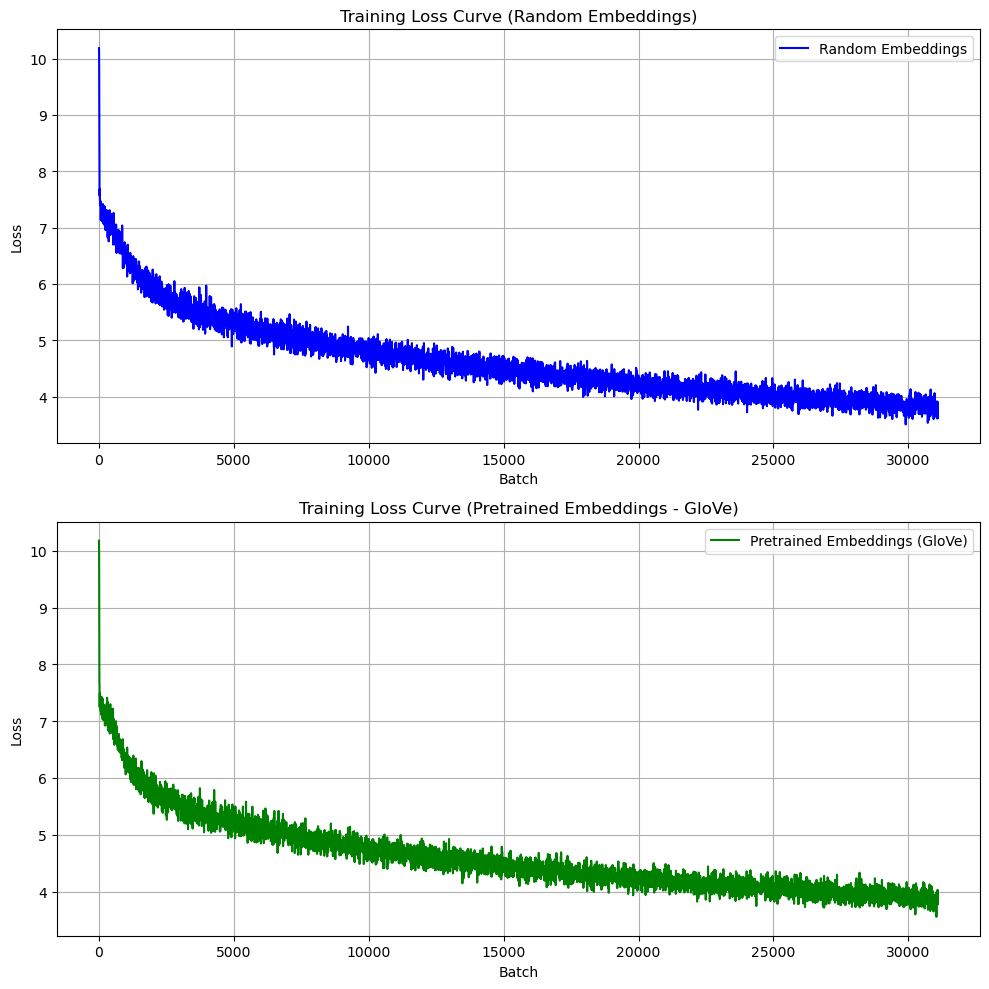

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 每隔 5 个点采样一次（太多了图就难看）
step = 5
random_losses_sampled = random_losses[::step]  
pretrained_losses_sampled = pretrained_losses[::step]  
epochs = np.arange(0, len(random_losses), step)  


plt.figure(figsize=(10, 10))  

# 第一个子图：绘制 Random Embeddings 的损失曲线
plt.subplot(2, 1, 1) 
plt.plot(epochs, random_losses_sampled, color='blue', label='Random Embeddings') 
plt.title('Training Loss Curve (Random Embeddings)') 
plt.xlabel('Batch') 
plt.ylabel('Loss') 
plt.legend()  
plt.grid(True)  

# 第二个子图：绘制 Pretrained Embeddings (GloVe) 的损失曲线
plt.subplot(2, 1, 2)  # 2行1列的第2个子图
plt.plot(epochs, pretrained_losses_sampled, color='green', label='Pretrained Embeddings (GloVe)')  
plt.title('Training Loss Curve (Pretrained Embeddings - GloVe)')  
plt.xlabel('Batch')
plt.ylabel('Loss')  
plt.legend()  
plt.grid(True)  

# 调整布局，避免子图重叠
plt.tight_layout()

# 显示图形
plt.show()

In [44]:
random_model.eval()
pretrained_model.eval()

random_perplexity = evaluate_perplexity(random_model, test_loader)
pretrained_perplexity = evaluate_perplexity(pretrained_model, test_loader)

print(f"Final Perplexity (Random Embeddings): {random_perplexity:.2f}")
print(f"Final Perplexity (Pretrained Embeddings): {pretrained_perplexity:.2f}")

Total non-padding tokens: 1105920
Total loss: 4145316.7944
Average loss: 3.7483
Perplexity: 42.45
Total non-padding tokens: 1105920
Total loss: 4223645.3047
Average loss: 3.8191
Perplexity: 45.56
Final Perplexity (Random Embeddings): 42.45
Final Perplexity (Pretrained Embeddings): 45.56
